In [12]:
using Distributions
using Random
using Plots
using PyPlot
using StatsBase
using StatsPlots
using Serialization
using LinearAlgebra

# Problem-Suite

Problem-Suite is a large structured notebook containing all of the functions created so far for this project.

Sections:

-[Miscellaneous Functions](#Miscellaneous-Functions)

-[Pre-requisite functions for uniformised AVI](#Pre-requisite-functions-for-uniformised-AVI)

-[Uniformised AVI functions](#Uniformised-AVI-functions)

-[Pre-requisite functions for SMARVI](#Pre-requisite-functions-for-SMARVI)

-[SMARVI Functions](#SMARVI-Functions)

-[Pre-requisite Functions for Exact DP on Homogeneous Problems](#Pre-requisite-Functions-for-Exact-DP-on-Homogeneous-Problems)

-[Exact DP on Homogeneous Problems (RVIA and PE/PI)](#Exact-DP-for-Homogeneous-problem)

-[Pre-requisite Functions for Exact DP on Inhomogeneous Problems](#Pre-requisite-Functions-for-Exact-DP-on-Inhomogeneous-Problems)

-[Exact DP on Inhomogeneous Problems (RVIA and PE/PI)](#Exact-DP-for-Inhomogeneous-Problem-(using-exact-h-or-VFA))

-[Evaluation via simulation](#Evaluation-via-simulation)

-[APE on Fully Active Policy](#APE-on-Fully-Active-Policy)

-[SMARPE](#SMARPE)

-[Tabular SMARVI and gEval](#tabular-smarvi-and-geval)

-[SMART Functions](#SMART-Functions)

-[SMARVI - New VFA](#SMARVI---New-VFA)

-[SMARPI New VFA Functions](#SMARPI-New-VFA-Functions)

-[DCP Heuristic](#dcp-heuristic)

-[Partially Deterministic VFA](#partially-deterministic-vfa)

-[Tests](#Tests)

-[Experiments on Small Problems](#Experiments-on-Small-Problems)

-[Experiments on Large Problems](#Experiments-on-Large-Problems)

# Miscellaneous Functions

-Functions for enumerating state and action spaces

-Functions for calculating flows given a state or state-action pair

-Function for evaluating a VFA at a given state

In [13]:
#produce an array of array representations of all possible states
function enumerateStates(N::Int64)
    if N==1
        return [[1],[2],[3]]
    end
    
    output = []
    lower = enumerateStates(N-1)
    for s in lower
        new1 = append!([1],s)
        new2 = append!([2],s)
        new3 = append!([3],s)
        append!(output,[new1])
        append!(output,[new2])
        append!(output,[new3])
    end
    
    return output
end

#produce an array of array representations of all possible actions
function enumerateActions(N::Int64)
    if N==1
        return [[0],[1]]
    end
    
    output = []
    lower = enumerateActions(N-1)
    for a in lower
        new1 = append!([0],a)
        new2 = append!([1],a)
        append!(output,[new1])
        append!(output,[new2])
    end
    
    return output
end    

#produce array of array representations of all restricted, or single-repair, actions
function enumerateRestrictedActions(N::Int64)
    if N==1
        return [[0],[1]]
    end
    
    output = [zeros(Int64,N)]
    for i in 1:N
        temp = zeros(N)
        temp[i] = 1
        append!(output,[temp])
    end
    
    return output
end

#convert all array elements to string, then concatanate all elements (DEPRECATED AS DICTS CAN TAKE ARRAYS AS KEYS)
function arrayToString(x)
    return join(string.(x))
end

arrayToString (generic function with 1 method)

In [14]:
#function for calculating the flows given a state
function calculateFlows(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
    #update flows
    flows = zeros(N)
    healthy = sum(i == 1 for i in s)
    
    #if no links are healthy, return 
    if healthy == 0
        return flows, c1
    end
    
    #otherwise, find best route, and return
    bestCost = maximum(c0) + 1
    usedLink = 0
    for k in 1:N
        if s[k] == 1 && c0[k] < bestCost
            bestCost = c0[k]
            usedLink = k
        end
    end
    
    flows[usedLink] = beta
    
    return flows, bestCost
end

#function for calculating the flows given a state-action pair
function calculateFlows(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
    sPrime = s - a
    return calculateFlows(sPrime,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
end

calculateFlows (generic function with 2 methods)

In [15]:
#evaluate a VFA at a given state
function v(s::Vector{Int64}, params::Vector{Float64}, features::Vector{Function})
    numFeatures = length(features)
    return params[1] + sum(params[i+1]*features[i](s) for i in 1:numFeatures)
end

v (generic function with 1 method)

In [16]:
#version of v that takes flows for the features
function v(s::Vector{Int64}, flows::Vector{Float64}, params::Vector{Float64}, features::Vector{Function})
    N = length(params)
    return params[1] + sum(params[i]*features[i-1](s, flows) for i in 2:N)
end

v (generic function with 2 methods)

In [17]:
#Note here that tau is a vector of independend repair rates
function calculatePi_SSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, lambda)
    mu = fill(0.0, N)
    nu = tau + alpha_r + lambda
    pi = fill(0.0, N, 3) #index by pi[edge, state]
    alpha_u = beta*alpha_d + alpha_r
    mu[1] = alpha_u[1]
    pi[1,1] = lambda[1]*tau[1]/(mu[1]*nu[1]+lambda[1]*tau[1])
    pi[1,2] = (lambda[1]/nu[1])*(1 - pi[1,1])
    pi[1,3] = 1 - pi[1,1] - pi[1,2]

    useprob = 1
    for i in 2:N
        useprob = useprob*(1 - pi[i-1,1])
        mu[i] = useprob*alpha_u[i] + (1 - useprob)alpha_r[i]
        normConst = mu[i]*nu[i] + lambda[i]*tau[i]
        pi[i,1] = tau[i]*lambda[i]/normConst
        pi[i,2] = (lambda[i]/nu[i])*(1 - pi[i,1])
        pi[i,3] = 1 - pi[i,1] - pi[i,2]
    end

    return pi
end

calculatePi_SSP (generic function with 1 method)

In [18]:
function calculateG_SSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, lambda)
    pi = calculatePi_SSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, lambda)
    prodNonHealthy = fill(0.0, N)
    prodNonHealthy[1] = 1 - pi[1,1]
    for i in 2:N
        prodNonHealthy[i] = prodNonHealthy[i-1]*(1 - pi[i,1])
    end

    return sum(r[i]*pi[i,2] for i in 1:N) + beta*c0[1]pi[1,1] + sum(beta*c0[i]*pi[i,1]*prodNonHealthy[i-1] for i in 2:N)+ beta*c1*prodNonHealthy[N], pi
end

calculateG_SSP (generic function with 1 method)

In [19]:
function calculateG_DSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, dsPolicy)
    if dsPolicy == fill(0,N)
        return beta*c1
    end
    S = []
    K = 0

    #calculate S the set of maintained links and K the number of maintained links
    prodNonHealthy = [1.0]
    prodNonHealthyCurrent = 1
    for i in 1:N
        if dsPolicy[i] == 1
            push!(S, i)
            K+=1
        end
    end

    #calculate p_AD(j in S, j<i) for all i in S, and p_AD(i in S)
    for i in S
        prodNonHealthyCurrent = prodNonHealthyCurrent*alpha_r[i]/(alpha_r[i] + tau[i])
        push!(prodNonHealthy, prodNonHealthyCurrent)
    end

    #calculate and return g
    return sum(r[S[i]]*alpha_r[S[i]]/(alpha_r[S[i]] + tau[S[i]]) + beta*c0[S[i]]*tau[S[i]]*prodNonHealthy[i]/(alpha_r[S[i]] + tau[S[i]]) for i in 1:K) + beta*c1*prodNonHealthy[K+1]
end

calculateG_DSP (generic function with 1 method)

In [20]:
function calculateG_DSP_extra(N,alpha_d, alpha_r, beta, tau, c0, c1, r, dsPolicy, fixedLinks)
    cheapFixedLink = minimum(fixedLinks)
    cheapFixedCost = c0[cheapFixedLink]

    if dsPolicy == fill(0,N)
        return beta*cheapFixedCost
    end
    S = []
    K = 0

    #calculate S the set of maintained links and K the number of maintained links
    prodNonHealthy = [1.0]
    prodNonHealthyCurrent = 1
    for i in 1:N
        if dsPolicy[i] == 1
            push!(S, i)
            K+=1
        end
    end

    #calculate p_AD(j in S, j<i) for all i in S, and p_AD(i in S)
    for i in S
        prodNonHealthyCurrent = prodNonHealthyCurrent*alpha_r[i]/(alpha_r[i] + tau[i])
        push!(prodNonHealthy, prodNonHealthyCurrent)
    end

    #calculate and return g
    return sum(r[S[i]]*alpha_r[S[i]]/(alpha_r[S[i]] + tau[S[i]]) + beta*min(c0[S[i]], cheapFixedCost)*tau[S[i]]*prodNonHealthy[i]/(alpha_r[S[i]] + tau[S[i]]) for i in 1:K)
end

calculateG_DSP_extra (generic function with 1 method)

In [21]:
function calculateG_SSP_Homog(N,alpha_d, alpha_r, beta, tau, c0, c1, r, lambdaActive, K)
    alpha_d = [alpha_d for i in 1:N]
    alpha_r = [alpha_r for i in 1:N]
    c0 = fill(c0, N)
    r = fill(r, N)
    lambda = fill(0.0, N)
    for i in 1:K
        lambda[i] = lambdaActive
    end

    return calculateG_SSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, lambda)
end

calculateG_SSP_Homog (generic function with 1 method)

In [22]:
#Computes the Fully Active action for a given state s
function faAction(s)
    N = length(s)
    a = zeros(Int64,N)
    for i in 1:N
        if s[i] == 3
            a[i] = 1
        end
    end
    return a
end

faAction (generic function with 1 method)

In [23]:
function sampleTruncExp(mean, upper)
    while true
        s = rand(Exponential(mean))
        if s < upper
            return s
        end
    end
end

sampleTruncExp (generic function with 1 method)

# Pre-requisite functions for uniformised AVI

This section contains functions used within the AVI algorithms

Given a state-action pair, return the next random pre-decision state, the instant cost, and the updated flows

In [24]:
function updateStateAndFlowsUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, flows)
    #immediate change
    sPrime = s - a
    healthy = sum(i == 1 for i in sPrime)
    repair = sum(i == 2 for i in sPrime)
    damaged = sum(i == 3 for i in sPrime)
    
    #observe exogenous information
    w = rand(Uniform(0, 1))
    
    #interpret exog info: is it a demand deg, rare deg, or completed repair 
    found = false
    runningTotal = 0
    
    #demand degs
    for k in 1:N
        if runningTotal <= w <= runningTotal + flows[k]*alpha_d[k]*del
            found = true
            sPrime[k] = 3
            #println("Demand Deg at "*string.(k))
            break
        end
        runningTotal = runningTotal + flows[k]*alpha_d[k]*del
    end
    
    #rare degs
    if found == false
        for k in 1:N
            if runningTotal <= w <= runningTotal + (s[k]!=3)*alpha_r[k]*del
                found = true
                sPrime[k] = 3
                #println("Rare Deg at "*string.(k))
                break
            end
            runningTotal = runningTotal + alpha_r[k]*del
        end
    end
    
    #repairs
    if found == false
        for k in 1:N
            if runningTotal <= w <= runningTotal + (s[k]==2)*tau[k]*del
                found = true
                sPrime[k] = 1
                break
            end
            runningTotal = runningTotal + (s[k]==2)*tau[k]*del
        end
    end
    
    if found == false
        #println("NO EVENT")
    end
    
    #update flows
    flowUpdate = calculateFlows(sPrime,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
    newFlows = flowUpdate[1]
    bestCost = flowUpdate[2]
    healthy = sum(i == 1 for i in sPrime)
    
    return sPrime, (beta*bestCost + sum(r[k]*(sPrime[k]==2) for k in 1:N))*del, newFlows
end

updateStateAndFlowsUnif (generic function with 1 method)

Given a state action pair, return the instant cost over the delta timestep.

In [25]:
#instant cost over the timestep
function instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    #immediate change
    sPrime = s - a
    healthy = sum(sPrime[i] == 1 for i in 1:N)
    repair = sum(sPrime[i] == 2 for i in 1:N)
    damaged = sum(sPrime[i] == 3 for i in 1:N)
    
    #update flows
    flowUpdate = calculateFlows(sPrime,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
    newFlows = flowUpdate[1]
    bestCost = flowUpdate[2]
    
    return (beta*bestCost + sum(r[k]*(sPrime[k]==2) for k in 1:N))*del
end

instantCostUnif (generic function with 1 method)

# Pre-requisite functions for SMARVI

Helper functions for the SMARVI algorithms

Given a state-action pair and pre-calculated flows, return the expected sojourn time for the state-action pair.

In [26]:
#Calculate the expected sojourn time of a state-action pair
function sojournTime(s, a, flows, N, alpha_d, alpha_r, beta, tau)
    s = s - a
    if s == fill(3,N)
        return 1/(beta*sum(alpha_d) + sum(alpha_r) + sum(tau))
    end
    
    
    totalRate = sum(flows[i]*alpha_d[i] + alpha_r[i]*(s[i]!=3) + tau[i]*(s[i]==2) for i in 1:N)
    
    return 1/totalRate
end

sojournTime (generic function with 1 method)

In [27]:
function sojournTime_MCP(s, mcp, flows, N, alpha_d, alpha_r, beta, tau)
    #deal with instant repairs
    for i in 1:N
        if s[i] == 3 && mcp[i] == -1
            return 0.0
        end
    end

    totalRate = sum(flows[i]*alpha_d[i] + alpha_r[i]*(s[i]!=3) + tau[i]*(s[i]==2) + mcp[i]*(s[i] == 3 && mcp[i]!= -1) for i in 1:N)

    return 1/totalRate
end

sojournTime_MCP (generic function with 1 method)

Given a state-action pair and flows, calculate the expected cost accumulated until a transition occurs, or calculate the simulated cost accumulated over a simulated time del.

In [28]:
#calculate the expected cost accumulated until a transition 
function instantCostCont(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows; del = 0)
    if del == 0
        del = sojournTime(s, a, flows, N, alpha_d, alpha_r, beta, tau)
    end
    
    return instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
end

instantCostCont (generic function with 1 method)

Given a state-action pair, return the next random pre-decision state, the cost accumulated over the sojourn time, and the updated flows

In [29]:
function updateStateAndFlowsCont(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
    #immediate change
    sPrime = s - a
    sOld = copy(sPrime)
    flowsOld = copy(flows)
    healthy = sum(i == 1 for i in sPrime)
    repair = sum(i == 2 for i in sPrime)
    damaged = sum(i == 3 for i in sPrime)
    
    #deal with all-damaged edge case
    if sPrime == fill(3, N)
        del = 1/(sum(beta*alpha_d) + sum(alpha_r) + sum(tau))
        return sPrime, beta*c1*del, flows, del
    end

    #create list of events (degradations for all non-damaged links and repair events for all repairing links) and list of rates
    events = [i for i in 1:N if sPrime[i]!=3]
    eventsRep = [N + i for i in 1:N if sPrime[i] == 2]
    append!(events, eventsRep)

    rates = [flows[i]*alpha_d[i] + alpha_r[i] for i in 1:N if sPrime[i]!=3]
    ratesRep = [tau[i] for i in 1:N if sPrime[i] == 2]
    append!(rates, ratesRep)

    #sample event
    del = 1/sum(rates)
    event = wsample(events, rates)

    #if event >= N+1, it's a repair, otherwise it's a degradation
    if event >= N + 1 
        sPrime[event - N] = 1
    else
        sPrime[event] = 3
    end
    
    #update flows
    flowUpdate = calculateFlows(sPrime,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
    newFlows = flowUpdate[1]
    bestCost = flowUpdate[2]
    
    return sPrime, (beta*c1*(healthy == 0) + sum(flowsOld[k]*c0[k] + r[k]*(sOld[k]==2) for k in 1:N))*del, newFlows, del
end

updateStateAndFlowsCont (generic function with 1 method)

Given a state and an MCP (mixed composite policy), return the post-transition state, the cost accumulated over the sojourn time, and the updated flows. 
MCP allows for exact instant repairs, and random repair starts, essentially allowing for a "soft" version of DCPs.

In [30]:
function updateStateAndFlowsCont_MCP(s,mcp,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
    #handle instant repairs
    sPrime = copy(s)
    instantChangeFlag = false
    for i in 1:N
        if sPrime[i] == 3 && mcp[i] == -1
            sPrime[i] = 2
            instantChangeFlag = true
        end
    end

    if instantChangeFlag
        return sPrime, 0.0, flows, 0.0
    end

    #main body
    sOld = copy(sPrime)
    flowsOld = copy(flows)
    healthy = sum(i == 1 for i in sPrime)
    repair = sum(i == 2 for i in sPrime)
    damaged = sum(i == 3 for i in sPrime)


    #create list of events (degradations for all non-damaged links and repair events for all repairing links) and list of rates
    events = [i for i in 1:N if sPrime[i]!=3]
    eventsRep = [N + i for i in 1:N if sPrime[i] == 2]
    eventsRepStart = [2*N + i for i in 1:N if mcp[i] != -1 && sPrime[i] == 3]
    append!(events, eventsRep)
    append!(events, eventsRepStart)

    rates = [flows[i]*alpha_d[i] + alpha_r[i] for i in 1:N if sPrime[i]!=3]
    ratesRep = [tau[i] for i in 1:N if sPrime[i] == 2]
    ratesRepStart = [mcp[i] for i in 1:N if mcp[i] != -1 && sPrime[i] == 3]
    append!(rates, ratesRep)
    append!(rates, ratesRepStart)

    #calculate sojourn time sample event
    del = 1/sum(rates)

    #sample event
    event = wsample(events, rates)
    
    #interpret event
    if event <= N
        sPrime[event] = 3 #degradation
    elseif N < event && event <= 2*N
        sPrime[event - N] = 1 #successful repair
    else
        sPrime[event - 2*N] = 2 #random repair Start
    end
    
    #update flows
    flowUpdate = calculateFlows(sPrime,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
    newFlows = flowUpdate[1]
    bestCost = flowUpdate[2]
    
    return sPrime, (beta*c1*(healthy == 0) + sum(flowsOld[k]*c0[k] + r[k]*(sOld[k]==2) for k in 1:N))*del, newFlows, del
end

updateStateAndFlowsCont_MCP (generic function with 1 method)

Generate random action for e-greedy algorithms

In [31]:
#Calculate random action for e-greedy algorithms
function randomAction(s,N)
    #deal with all-damaged case
    if s == fill(3,N)
        return randomActionAllDamaged(N)
    end

    damaged = [0]
    for i in 1:N
        if s[i] == 3
            append!(damaged, [i])
        end
    end
            
    choice = sample(damaged)
    optA = zeros(Int64, N)
    if choice == 0
        return optA
    else
        optA[choice] = 1
        return optA
    end
end

#calculate random action for [3,3...,3] state
function randomActionAllDamaged(N)
    choice = sample(1:N)
    a = zeros(Int64, N)
    a[choice] = 1
    return a
end

randomActionAllDamaged (generic function with 1 method)

# Pre-requisite Functions for Exact DP on Homogeneous Problems 

Helper functions for Homogeneous Exact DP

Calculates instant cost for homogeneous problem

In [32]:
#instant cost function strictly for homogeneous problem
function instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    #immediate change
    i1Prime = i1 - a
    i2Prime = i2 + a
    
    #if no links are healthy, return 
    if N - i1 - i2 == 0
        return (beta*c1 + r*i2Prime)*del
    end
    
    
    return (beta*c0 + r*i2Prime)*del
end

instantCostHomog (generic function with 1 method)

Given state (i_1, i_2) and action a, calculates the expected next value function after one timestep

In [33]:
#calculates E(h(s')) from s,a strictly for a homogeneous problem
function expectedNextValueHomog(i1,i2, h, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    #immediate change
    i1Prime = i1 - a
    i2Prime = i2 + a
    thisH = h[i1+1,i2+1]
    
    #if all are damaged
    if i1Prime == N
        return thisH
    end
    
    #if none are healthy
    if N - i1 - i2 == 0
        return thisH + tau*i2Prime*del*(h[i1Prime+1,i2Prime-1+1] - thisH) + i2Prime*del*alpha_r*(h[i1Prime+1+1, i2Prime-1+1] - thisH)
    end
    
    #if none are repairing
    if i2Prime == 0
        return thisH + (beta*alpha_d + (N - i1 - i2)*alpha_r)*del*(h[i1Prime+1+1,i2Prime+1] - thisH)
    end
    
    return thisH + (beta*alpha_d + (N - i1 - i2)*alpha_r)*del*(h[i1Prime+1+1,i2Prime+1] - thisH) + i2Prime*alpha_r*del*(h[i1Prime+1+1,i2Prime-1+1] - thisH) + tau*i2Prime*del*(h[i1Prime+1,i2Prime-1+1] - thisH)
end

expectedNextValueHomog (generic function with 1 method)

Given state (i_1,i_2) and value function h, calculates and returns the best action for the state using full expectations.

In [34]:
#calculates the exact PI action strictly for a homogeneous problem
function piActionHomog(i1, i2, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del; forceActive = false)
    if i1 == 0
        return 0
    end
    
    if i1 == N && forceActive
        optA = 1
        optH = instantCostHomog(i1,i2,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
        for a in 2:i1
            testH = instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
            if testH <= optH
                optA = a
                optH = testH
            end
        end
        return optA
    end
    
    optA = 0
    optH = instantCostHomog(i1,i2,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    for a in 1:i1
        testH = instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
        if testH <= optH
            optA = a
            optH = testH
        end
    end
    
    return optA
end

piActionHomog (generic function with 1 method)

Similar to above, but uses the approximation Q(s,a) = h(s+a) for a!=0

In [35]:
#calculates the approx PI action based on instantaneous approximation, strictly for a homogeneous problem
function piActionHomogApprox(i1, i2, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g; forceActive = false)
    #deal with "nothing damaged" edge case
    if i1 == 0
        return 0
    end
    
    #deal with "everything damaged" edge case
    if i1 == N && forceActive
        optA = 1
        optH = h[i1-optA+1,i2+optA+1]
        for a in 2:i1
            testH = h[i1-a+1,i2+a+1]
            if testH <= optH
                optA = a
                optH = testH
            end
        end
        return optA
    end
    
    optA = 0
    optH = instantCostHomog(i1,i2,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) - g*del
    for a in 1:i1
        testH = h[i1-a+1,i2+a+1]
        if testH <= optH
            optA = a
            optH = testH
        end
    end
    
    return optA
end

piActionHomogApprox (generic function with 1 method)

Given h, constructs optimal policy using exact PI method

In [36]:
#calculates the exact PI policy strictly for a homogeneous problem
function piPolicyHomog(h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del; forceActive = false)
    policy = zeros(Int64, N+1, N+1)
    for i1 in 0:N
        for i2 in 0:(N - i1)
            policy[i1+1,i2+1] = piActionHomog(i1, i2, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del; forceActive = forceActive)
        end
    end
    
    return policy
end

piPolicyHomog (generic function with 1 method)

Given h, constructs optimal policy using Q(s,a) = h(s,a) for a!=0 approximation

In [37]:
#calculates the approx PI policy based on instantaneous approximation, strictly for a homogeneous problem
function piPolicyHomogApprox(h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g; forceActive = false)
    policy = zeros(Int64, N+1, N+1)
    for i1 in 0:N
        for i2 in 0:(N - i1)
            policy[i1+1,i2+1] = piActionHomogApprox(i1, i2, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g; forceActive = forceActive)
        end
    end
    
    return policy
end

piPolicyHomogApprox (generic function with 1 method)

Constructs a h table from a VFA

In [38]:
function hFromVFAHomog(N, params, features)
    #construct hIn table
    hIn = zeros(Float64, N+1, N+1)
    for i1 in 0:N
        for i2 in 0:(N - i1)
            s = fill(1,N)
            if i1 > 0
                for i in 1:i1
                    s[i] = 3
                end
            end
            
            if i2 > 0
                for i in (i1+1):(i1+i2)
                    s[i] = 2
                end
            end
            
            hIn[i1+1,i2+1] = v(s, params, features)
        end
    end
    
    return hIn
end

hFromVFAHomog (generic function with 1 method)

# Exact DP for Homogeneous problem

Actual DP algorithms 

Given a h table, performs PE on PI policy derived from h, and returns g, h, n (number of iterations), and the PI policy

In [39]:
#Evaluates a PI policy based on a given exact h function, strictly for a homogeneous problem 
function rpiHomog(N::Int64, hIn, alpha_d::Float64, alpha_r::Float64, beta::Float64, tau, c0::Float64, c1::Float64, r::Float64, epsilon::Float64; nMax = 0, delScale = 1, forceActive = false)
    #calculate stepsize and initialise h,w,and policy vectors
    del = 1/(delScale*(beta*alpha_d + N*alpha_r + N*tau))
    h = zeros(Float64, N+1, N+1)
    w = zeros(Float64, N+1, N+1)
    policy = piPolicyHomog(hIn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del; forceActive = forceActive)
    n = 0
    #repeat until epsilion-convergence or n = nMax
    while true
        n = n + 1
        #calculate new w values
        for i1 in 0:N
            for i2 in 0:(N - i1)
                a = policy[i1+1,i2+1]
                w[i1+1,i2+1] = instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
            end
        end
        
        
        #calculate new relative values
        hNew = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:(N - i1)
                hNew[i1+1,i2+1] = w[i1+1,i2+1] - w[1,1]
            end
        end
        
        #check for convergence
        deltas = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:N-i1
                deltas[i1+1,i2+1] = hNew[i1+1,i2+1] - h[i1+1,i2+1]
            end
        end
        
        h = hNew
        if maximum(deltas) < epsilon || n == nMax
            break
        end
    end
    
    v = beta*c0*del + (beta*alpha_d + (N)*alpha_r)*del*h[1+1,0+1] + (1 - (beta*alpha_d + (N)*alpha_r)*del)*h[0+1,0+1]
    
    return v/del, h, n, policy
end

rpiHomog (generic function with 1 method)

Performs PE on the fully active policy

In [40]:
#Evaluates the fully active policy, strictly for a homogeneous problem 
function rpeFAHomog(N::Int64, alpha_d::Float64, alpha_r::Float64, beta::Float64, tau, c0::Float64, c1::Float64, r::Float64, epsilon::Float64; nMax = 0, delScale = 1, forceActive = false)
    #calculate stepsize and initialise h,w,and policy vectors
    del = 1/(delScale*(beta*alpha_d + N*alpha_r + N*tau))
    h = zeros(Float64, N+1, N+1)
    w = zeros(Float64, N+1, N+1)
    n = 0
    #repeat until epsilion-convergence or n = nMax
    while true
        n = n + 1
        #calculate new w values
        for i1 in 0:N
            for i2 in 0:(N - i1)
                a = i1
                w[i1+1,i2+1] = instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
            end
        end
        
        
        #calculate new relative values
        hNew = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:(N - i1)
                hNew[i1+1,i2+1] = w[i1+1,i2+1] - w[1,1]
            end
        end
        
        #check for convergence
        deltas = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:N-i1
                deltas[i1+1,i2+1] = hNew[i1+1,i2+1] - h[i1+1,i2+1]
            end
        end
        
        h = hNew
        if maximum(deltas) < epsilon || n == nMax
            break
        end
    end
    
    v = beta*c0*del + (beta*alpha_d + (N)*alpha_r)*del*h[1+1,0+1] + (1 - (beta*alpha_d + (N)*alpha_r)*del)*h[0+1,0+1]
    
    return v/del, h, n
end

rpeFAHomog (generic function with 1 method)

Similar to rpiHomog, but uses Q(s,a) = h(s,a) approximation for PI step.

In [41]:
#Evaluates an approximate PI policy based on a given exact h function and instananeous actions, strictly for a homogeneous problem 
function rpiHomogApprox(N::Int64, hIn, alpha_d::Float64, alpha_r::Float64, beta::Float64, tau, c0::Float64, c1::Float64, r::Float64, epsilon::Float64, g::Float64; nMax = 0, delScale = 1, forceActive = false)
    #calculate stepsize and initialise h,w,and policy vectors
    del = 1/(delScale*(beta*alpha_d + N*alpha_r + N*tau))
    h = zeros(Float64, N+1, N+1)
    w = zeros(Float64, N+1, N+1)
    policy = piPolicyHomogApprox(hIn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g; forceActive = forceActive)
    n = 0
    #repeat until epsilion-convergence or n = nMax
    while true
        n = n + 1
        #calculate new w values
        for i1 in 0:N
            for i2 in 0:(N - i1)
                a = policy[i1+1,i2+1]
                w[i1+1,i2+1] = instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
            end
        end
        
        
        #calculate new relative values
        hNew = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:(N - i1)
                hNew[i1+1,i2+1] = w[i1+1,i2+1] - w[1,1]
            end
        end
        
        #check for convergence
        deltas = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:N-i1
                deltas[i1+1,i2+1] = hNew[i1+1,i2+1] - h[i1+1,i2+1]
            end
        end
        
        h = hNew
        if maximum(deltas) < epsilon || n == nMax
            break
        end
    end
    
    v = beta*c0*del + (beta*alpha_d + (N)*alpha_r)*del*h[1+1,0+1] + (1 - (beta*alpha_d + (N)*alpha_r)*del)*h[0+1,0+1]
    
    return v/del, h, n, policy
end

rpiHomogApprox (generic function with 1 method)

Performs RVIA

In [42]:
#Performs RVIA 
function rviHomog(N::Int64, alpha_d::Float64, alpha_r::Float64, beta::Float64, tau, c0::Float64, c1::Float64, r::Float64, epsilon::Float64; nMax = 0, delScale = 1, forceActive = false)
    #calculate stepsize and initialise h,w,and policy vectors
    del = 1/(delScale*(beta*alpha_d + N*alpha_r + N*tau))
    h = zeros(Float64, N+1, N+1)
    w = zeros(Float64, N+1, N+1)
    n = 0
    #repeat until epsilion-convergence or n = nMax
    while true
        n = n + 1
        #calculate new w values
        for i1 in 0:N
            for i2 in 0:(N - i1)
                a = piActionHomog(i1, i2, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del; forceActive = forceActive)
                w[i1+1,i2+1] = instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
            end
        end
        
        
        #calculate new relative values
        hNew = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:(N - i1)
                hNew[i1+1,i2+1] = w[i1+1,i2+1] - w[1,1]
            end
        end
        
        #check for convergence
        deltas = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:N-i1
                deltas[i1+1,i2+1] = hNew[i1+1,i2+1] - h[i1+1,i2+1]
            end
        end
        
        h = hNew
        if maximum(deltas) < epsilon || n == nMax
            break
        end
    end
    
    v = beta*c0*del + (beta*alpha_d + (N)*alpha_r)*del*h[1+1,0+1] + (1 - (beta*alpha_d + (N)*alpha_r)*del)*h[0+1,0+1]
    
    return v/del, h, n, piPolicyHomog(h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del; forceActive = false)
end

rviHomog (generic function with 1 method)

# Pre-requisite Functions for Exact DP on Inhomogeneous Problems

Helper functions for inhomogeneous exact DP

Given a state-action pair and h, calculates the expected next value of the value function after one timestep.

In [43]:
#calculates E(h(s')) from s,a using exact h table
function expectedNextValueExact(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h)
    #immediate change
    sPrime = s - a
    healthy = sum(i == 1 for i in sPrime)
    repair = sum(i == 2 for i in sPrime)
    damaged = sum(i == 3 for i in sPrime)
    
    runningTotal = 0.0
    runningTotalProb = 0.0
    
    flows = zeros(Float64, N)
    if healthy > 0
        #otherwise, find best route, and return
        bestCost = maximum(c0) + 1
        usedLink = 0
        for k in 1:N
            if sPrime[k] == 1 && c0[k] < bestCost
                bestCost = c0[k]
                usedLink = k
            end 
        end
        
        flows[usedLink] = beta
    end
    
    
    #demand degs
    for k in 1:N
        sNext = copy(sPrime)
        sNext[k] = 3
        runningTotal += flows[k]*alpha_d[k]*del*h[sNext]
        runningTotalProb += flows[k]*alpha_d[k]*del
    end
    
    #rare degs
    for k in 1:N
        if sPrime[k] != 3
            sNext = copy(sPrime)
            sNext[k] = 3
            runningTotal += alpha_r[k]*del*h[sNext]
            runningTotalProb += alpha_r[k]*del
        end
    end
    
    #repairs
    for k in 1:N
        if sPrime[k] == 2
            sNext = copy(sPrime)
            sNext[k] = 1
            runningTotal += tau[k]*del*h[sNext]
            runningTotalProb += tau[k]*del
        end
    end
    
    return runningTotal + (1 - runningTotalProb)*h[sPrime]
end 

expectedNextValueExact (generic function with 1 method)

Given a state and a h table, calculates the PI action for s.

In [44]:
#calculates PI action using exact h table
function piActionExact(s, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del; actionType = "restricted")
    if s == fill(1, N)
        return zeros(Int64, N)
    end
    
    optA = zeros(Int64, N)
    optH = instantCostUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del,h)

    if actionType == "restricted"
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64,N)
                a[i] = 1
                testH = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del,h)
                if testH < optH
                    optA = a
                    optH = testH
                end
            end
        end
        return optA
    elseif actionType == "full"
        actionSpace = enumerateActions(N)
        for a in actionSpace
            check = true
            for i in 1:N
                if a[i] == 1 && s[i]!=3
                    check = false
                    break
                end
            end

            if check
                testH = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del,h)
                if testH < optH
                    optA = a
                    optH = testH
                end
            end
        end

        return optA
    else
        return "ERROR"
    end
end

piActionExact (generic function with 1 method)

Similar to above, but uses the approximation Q(s,a) = h(s+a)

In [45]:
#calculates PI action using exact h table, based off instananeous actions
function piActionExactInstant(s, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    if s == fill(1, N)
        return zeros(Int64, N)
    end
    
    optA = zeros(Int64, N)
    optH = instantCostUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del,h) - g*del
    for i in 1:N
        if s[i] == 3
            a = zeros(Int64,N)
            a[i] = 1
            testH = h[s-a]
            if testH < optH
                optA = a
                optH = testH
            end
        end
    end
    return optA
end

piActionExactInstant (generic function with 1 method)

Constructs PI policy using h table and no approximation

In [46]:
#calculates PI policy using exact h table
function piPolicyExact(h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del; actionType = "restricted")
    policy = Dict()
    stateSpace = enumerateStates(N)
    for s in stateSpace
        policy[s] = piActionExact(s, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del; actionType = actionType)
    end
    
    return policy
end

piPolicyExact (generic function with 1 method)

Constructs PI policy using h table and Q(s,a) = h(s+a) approximation

In [47]:
#calculates PI policy using exact h table, interpretting h with instant actions
function piPolicyExactInstant(h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    policy = Dict()
    stateSpace = enumerateStates(N)
    for s in stateSpace
        policy[s] = piActionExactInstant(s, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    end
    
    return policy
end

piPolicyExactInstant (generic function with 1 method)

# Exact DP for Inhomogeneous Problem (using exact h or VFA)

DP algorithms for inhomogeneous problem

Note that throughout when we talk of a Q(s,a) = h(s+a) approximation, this only refers to action selection and not update rules, and excludes a=0

Given an explicit policy table, performs PE, returns g, h and n (# of iterations)

In [48]:
#Performs PE using exact policy table
function rpe(N, policy, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    #calculate stepsize and initialise h,w,and policy dictionaries
    del = 1/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + sum(tau)))
    h = Dict()
    w = Dict()
    stateSpace = enumerateStates(N)
    actionSpace = enumerateRestrictedActions(N)
    for s in stateSpace
        h[s] = 0.0
        w[s] = 0.0
    end
    s0  = fill(1, N)
    n = 0
    
    #do until max iterations met or epsilon convergence
    while true
        n = n + 1
        #find updates for every state
        for s in stateSpace
            a = policy[s]
            w[s] = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h)
        end
        
        #calculate relative values and delta
        delta = 0
        for s in stateSpace
            update = w[s] - w[s0]
            if delta < update - h[s] || delta == 0
                delta = update - h[s]
            end
            
            h[s] = update
        end
        
        #stopping condition
        if delta < epsilon || n == nMax
            break
        end
        
        if printProgress && n%modCounter == 0
            println(n)
        end
    end
    
    a = zeros(Int64, N)
    g = instantCostUnif(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h) - h[s0]
    
    return g/del, h, n
end

rpe (generic function with 1 method)

Given a h table, constructs PI policy and performs PE, returning g, h, n and the PI policy

In [49]:
#Performs one round of exact PI and PE using exact h table
function rpiExact(N, hIn, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = 0, delScale = 1, printProgress = false, modCounter = 100, actionType = "restricted")
    del = 1/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + sum(tau)))
    policy = piPolicyExact(hIn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del; actionType = actionType)
    output = rpe(N, policy, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = nMax, delScale = delScale, printProgress = printProgress, modCounter = modCounter)
    return output[1], output[2], output[3], policy
end

rpiExact (generic function with 1 method)

Similar to above, but uses Q(s,a) = h(s+a) approximation

In [50]:
#Performs one round of exact PI and PE using exact h table, using instant actions to interpet h
function rpiExactInstant(N, hIn, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon, g; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    #calculate stepsize and initialise h,w,and policy dictionaries
    del = 1/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + sum(tau)))
    policy = piPolicyExactInstant(hIn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    output = rpe(N, policy, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = nMax, delScale = delScale, printProgress = printProgress, modCounter = modCounter)
    return output[1], output[2], output[3], policy
end

rpiExactInstant (generic function with 1 method)

Performs PE on the fully active policy

In [51]:
#Performs exact PE on the fully-active policy
function rpeFA(N, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    stateSpace = enumerateStates(N)
    policy = Dict()
    for s in stateSpace
        policy[s] = faAction(s)
    end
    
    return rpe(N, policy, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = nMax, delScale = delScale, printProgress = printProgress, modCounter = modCounter)
end

rpeFA (generic function with 1 method)

Performs PE on fully passive policy

In [52]:
#Performs exact PE on the passive policy
function rpePassive(N, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    policy = Dict()
    for s in stateSpace
        policy[s] = zeros(Int64, N)
    end
    
    return rpe(N, policy, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = nMax, delScale = delScale, printProgress = printProgress, modCounter = modCounter)
end

rpePassive (generic function with 1 method)

Performs RVIA

In [53]:
#Performs RVIA
function rvi(N, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = 0, delScale = N, printProgress = true, modCounter = 1000, actionType = "restricted")
    #calculate stepsize and initialise h,w,and policy dictionaries
    del = 1/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + sum(tau)))
    h = Dict()
    w = Dict()
    policy = Dict()
    stateSpace = enumerateStates(N)
    if actionType == "restricted"
        actionSpace = enumerateRestrictedActions(N)
    elseif actionType == "full"
        actionSpace = enumerateActions(N)
    else
        return "ERROR"
    end

    for s in stateSpace
        h[s] = 0.0
        w[s] = 0.0
        policy[s] = zeros(Int64,N)
    end
    s0  = fill(1, N)
    n = 0
    
    #do until max iterations met or epsilon convergence
    while true
        n = n + 1
        #find updates for every state
        for s in stateSpace
            a = piActionExact(s, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del; actionType = actionType)
            w[s] = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h)
            policy[s] = a
        end
        
        #calculate relative values and delta
        delta = 0
        for s in stateSpace
            update = w[s] - w[s0]
            if delta < update - h[s] || delta == 0
                delta = update - h[s]
            end
            
            h[s] = update
        end
        
        #stopping condition
        if delta < epsilon || n == nMax
            break
        end
        
        if printProgress && n%modCounter == 0
            println(n)
        end
    end
    
    a = zeros(Int64, N)
    g = instantCostUnif(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h) - h[s0]
    
    return g/del, h, n, policy
end

rvi (generic function with 1 method)

# Evaluation via simulation

Various evaluation functions for approximating g

Finds the g of the fully active policy

In [54]:
#Evaluates the FA policy
function gEvaluationFA(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax; s = fill(1,N), printProgress = false, modCounter = 100000, stateTrace = false)
    #initialise
    s0 = fill(1,N)
    flows = zeros(N)
    runningTotal = 0.0
    timePassed = 0.0
    runningTotals = [0.0]
    times = [0.0]
    g = 0.0
    gs = [g]
    
    #initialise flows
    flows = calculateFlows(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r)[1]
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        
        #formulate FA action
        bestA = faAction(s)
        
        if stateTrace
            println(s)        
        end

        #update state, flows and g
        if bestA == zeros(Int64, N)
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            s = result[1]
            c = result[2]
            flows = result[3]
            time = result[4]
            g = (g*timePassed + c)/(timePassed + time)
            timePassed += time
        else
            s = s - bestA
        end
        
        append!(gs,[g])
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return g, gs, timePassed
end

gEvaluationFA (generic function with 1 method)

In [55]:
#Evaluates a Deterministic Static Policy (e-soft)
function gEvaluationDSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, dsPolicy; s = fill(1, N),  epsilon = -1.0, printProgress = false, modCounter = 100000, forceActive = false, stateTrace = false)
    #initialise
    flows = zeros(N)
    runningTotal = 0.0
    timePassed = 0.0
    runningTotals = [0.0]
    times = [0.0]
    g = 0.0
    gs = [g]
    
    #initialise flows
    flows = calculateFlows(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r)[1]
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        if stateTrace
            println(s)
        end
        
        #formulate DSP action
        bestA = fill(0, N)
        if rand(Uniform(0,1)) > epsilon
            for i in 1:N
                if s[i] == 3 && dsPolicy[i] == 1
                    bestA[i] = 1
                end
            end
        else
            bestA = randomAction(s, N)
        end
        
        #update state, flows and g
        if bestA == zeros(Int64, N)
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            s = result[1]
            c = result[2]
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        append!(gs,[g])
        append!(runningTotals, [runningTotal])
        append!(times,[timePassed])
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return g, gs, runningTotals, times, s
end

gEvaluationDSP (generic function with 1 method)

In [56]:
function gEvaluationMCP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, mcp; s = fill(1,N), timePassed = 0.0, printProgress = false, modCounter = 100000, printStates = false)
    #initialise
    epsilon = -1.0
    s0 = [1 for i in 1:N]

    flows = zeros(N)
    g = 0.0
    gs = [g]
    
    #initialise flows
    flows = calculateFlows(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r)[1]

    #do nMax iterations of evaluation
    for n in 1:nMax
        
        #update state, flows and g
        result = updateStateAndFlowsCont_MCP(s,mcp,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        c = result[2]
        s = sPrime
        flows = result[3]
        time = result[4]
            
        if time > 0.0
            g = (g*timePassed + c)/(timePassed + time)
            timePassed += time
        end

        push!(gs, g)

        if printStates 
            println(s)
        end
        
        if printProgress == true && n%modCounter == 0
            println(n)
        end
    end

    return g, gs
end

gEvaluationMCP (generic function with 1 method)

# Tabular SMARVI and gEval

Tabular SMARVI algorithms (non e-greedy, e-greedy, and e-greedt with state trace), associated gEval function, and helper functions

Given a state s, its flows, and a h-g pair, return the optimal action and V value for s

In [57]:
function smarActionAndVFromTable(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, h, g)
    #find optimal action
    optA = zeros(Int64,N)
    t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
    optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContTab(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, h) - g*t
        
    for i in 1:N
        if s[i] == 3
            a = zeros(Int64, N)
            a[i] = 1
               
            if h[s-a] <= optV
                optV = h[s-a]
                optA = a
            end
        end
    end
        
    #Fix choose optimal non-passive action if state is [3,3,...,3]
    if s == fill(3,N) && optA == zeros(Int64, N)
        optA[1] = 1
        optV = h[s-optA]
            
        for i in 2:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                testV = h[s-a]
                if testV <= optV
                    optV = testV
                    optA = a
                end
            end
        end
    end

    return optA, optV
end

smarActionAndVFromTable (generic function with 1 method)

Given a state-action pair and a h table, compute the next expected h value given that a transition has occured

In [58]:
#Calculates E(h(s')) given a state-action pair, and tabular h
function expectedNextValueContTab(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, h)
    del = sojournTime(s, a, flows, N, alpha_d, alpha_r, beta, tau)
    #immediate change
    sPrime = s - a
    
    #different treatment for all-damaged state
    if sPrime == fill(3,N)
        return h[sPrime]
    end
    
    runningTotal = 0
    
    #demand degs
    for k in 1:N
        sNext = copy(sPrime)
        sNext[k] = 3
        runningTotal += flows[k]*alpha_d[k]*del*h[sNext]
    end
    
    #rare degs
    for k in 1:N
        if sPrime[k] != 3
            sNext = copy(sPrime)
            sNext[k] = 3
            runningTotal += alpha_r[k]*del*h[sNext]
        end
    end
    
    #repairs
    for k in 1:N
        if sPrime[k] == 2
            sNext = copy(sPrime)
            sNext[k] = 1
            runningTotal += tau[k]*del*h[sNext]
        end
    end
    
    return runningTotal
end   

expectedNextValueContTab (generic function with 1 method)

Tabular SMARVI, without ST (set epsilon = 0 for full-exploitation)

In [59]:
#Performs AVI in the continuous time setting, approximating E(h(s')) using all possible transitions
#Uses tabular representation instead of VFA and e-greedy action selection
function smarviTab(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, b, c; printProgress = false, modCounter = 100000, stateDepEpsilon = false)
    #initialise
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    stateSpace = enumerateStates(N)
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    gs = [g]

    h = Dict()
    for s in stateSpace
        h[s] = 0.0
    end
    
    numVisits = Dict()
    for s in stateSpace
        numVisits[s] = 0
    end
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #update numVisits
        numVisits[s] += 1

        #formulate optimal action
        optAandV = smarActionAndVFromTable(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, h, g)
        optA = optAandV[1]
        optV = optAandV[2]
        
        epsilon = c/(c + n)
        if stateDepEpsilon
            epsilon = c/(c + numVisits[s])
        end

        if rand(Uniform(0,1)) < epsilon
            optA = randomAction(s, N)
            if optA == zeros(Int64, N)
                t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
                optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContTab(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, h) - g*t
            else
                optV = h[s - optA]
            end    
        end 
        
        bestA = optA
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #find value of v^n:
        bestV = optV - h[s0]
        
        #update VFA
        currentEst = h[s]
        h[s] += (b/(b + numVisits[s]))*(bestV - currentEst)
        
        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        push!(gs, g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return h, g, gs
end

smarviTab (generic function with 1 method)

Similar to above, but incorporates the state trace

In [60]:
#Uses tabular representation instead of VFA, e-greedy action selection, and state trace 
function smarviTab_ST(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, b, c; printProgress = false, modCounter = 100000, stateDepEpsilon = false)
    #initialise
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    stateSpace = enumerateStates(N)
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    gs = [g]
    stateTrace = []
    h = Dict()
    for s in stateSpace
        h[s] = 0.0
    end
    
    numVisits = Dict()
    for s in stateSpace
        numVisits[s] = 0
    end
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #update numVisits
        numVisits[s] += 1

        #update trace
        push!(stateTrace, s)

        #formulate optimal action
        optAandV = smarActionAndVFromTable(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, h, g)
        optA = optAandV[1]
        optV = optAandV[2]
        
        #choose epsilon
        epsilon = c/(c + n)
        if stateDepEpsilon
            epsilon = c/(c + numVisits[s])
        end

        #choose actual action
        if rand(Uniform(0,1)) < epsilon
            optA = randomAction(s, N)
            if optA == zeros(Int64, N)
                t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
                optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContTab(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, h) - g*t
            else
                optV = h[s - optA]
            end    
        end 
        
        bestA = optA
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #find value of v^n:
        bestV = optV - h[s0]
        
        #update VFA
        if bestA == zeros(Int64, N)
            for st in stateTrace
                currentEst = h[st]
                h[st] += (b/(b + numVisits[st]))*(bestV - currentEst)
            end
            stateTrace = []
        end

        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        push!(gs, g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return h, g, gs
end

smarviTab_ST (generic function with 1 method)

Similar to above (so e-greedy and state trace), but uses a moving average window to approximate g, allowing old estimates to be discarded

In [61]:
#Tabular SMARVI with moving average online approximation for g, e-greedy action selection, and state trace
function smarviTabMA(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, b, c; window = 2500000, printProgress = false, modCounter = 100000, stateDepEpsilon = false)
    #initialise
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    stateSpace = enumerateStates(N)
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    totalCosts = [0.0]
    timePassed = 0.0
    totalTimes = [0.0]
    lenTotals = 1
    g = 0.0
    gs = [g]
    stateTrace = []
    h = Dict()
    for s in stateSpace
        h[s] = 0.0
    end
    
    numVisits = Dict()
    for s in stateSpace
        numVisits[s] = 0
    end
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #update numVisits
        numVisits[s] += 1

        #update trace
        push!(stateTrace, s)

        #formulate optimal action
        optAandV = smarActionAndVFromTable(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, h, g)
        optA = optAandV[1]
        optV = optAandV[2]
        
        #choose epsilon
        epsilon = c/(c + n)
        if stateDepEpsilon
            epsilon = c/(c + numVisits[s])
        end

        #choose actual action
        if rand(Uniform(0,1)) < epsilon
            optA = randomAction(s, N)
            if optA == zeros(Int64, N)
                t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
                optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContTab(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, h) - g*t
            else
                optV = h[s - optA]
            end    
        end 
        
        bestA = optA
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #find value of v^n:
        bestV = optV - h[s0]
        
        #update VFA
        if bestA == zeros(Int64, N)
            for st in stateTrace
                currentEst = h[st]
                h[st] += (b/(b + numVisits[st]))*(bestV - currentEst)
            end
            stateTrace = []
        end

        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            push!(totalCosts, runningTotal)
            push!(totalTimes, timePassed)
            lenTotals += 1
            if lenTotals <= window
                g = runningTotal/timePassed
            else
                g = (runningTotal - totalCosts[lenTotals - window])/(timePassed - totalTimes[lenTotals - window])
            end
        else
            s = s - bestA
        end
        
        push!(gs, g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return h, g, gs
end

smarviTabMA (generic function with 1 method)

Given a state, a h table and g, return the PI action for s. Uses the Q(s,a) = h(s+a) approximation

In [62]:
#calculates PI action using exact h table, based off continuous model
function piActionExactCont(s, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, g)
    if s == fill(1, N)
        return zeros(Int64, N)
    end
    
    flows = calculateFlows(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r)[1]
    
    optA = zeros(Int64, N)
    t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
    optH = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContTab(s, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows,h) - g*t
    for i in 1:N
        if s[i] == 3
            a = zeros(Int64,N)
            a[i] = 1
            testH = h[s-a]
            if testH < optH
                optA = a
                optH = testH
            end
        end
    end

    if s == fill(3,N) && optA == zeros(Int64, N)
        optA[1] = 1
        optH = h[s - optA]

        for i in 2:N
            a = zeros(Int64, N)
            a[i] = 1
            testH = h[s - a]
            if testH < optH
                optA = a
                optH = testH
            end
        end
    end

    return optA
end

piActionExactCont (generic function with 1 method)

Constructs a PI policy using the above method

In [63]:
function piPolicyExactCont(h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, g)
    stateSpace = enumerateStates(N)
    policy = Dict()
    for s in stateSpace
        policy[s] = piActionExactCont(s, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, g)
    end

    return policy
end

piPolicyExactCont (generic function with 1 method)

Given a h table and fixed g0, approximates the g of the PI policy derived using the above function

In [64]:
function gEvaluationTab(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, h, g0; printProgress = false, modCounter = 100000)
    #initialise
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    stateSpace = enumerateStates(N)
    println("State Space Completed")
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    gs = [g]
    
    policy = piPolicyExactCont(h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, g0)
    println("Policy Completed")

    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action
        bestA = policy[s]
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        push!(gs, g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return g, gs, policy
end

gEvaluationTab (generic function with 1 method)

Returns an array of feasible actions for N-dim state s

In [65]:
function enumerateFeasibleActions(s,N)
    actionSpace = []
    if s == fill(3, N)
        for i in 1:N
            a = zeros(Int64, N)
            a[i] = 1
            push!(actionSpace, a)
        end
        return actionSpace
    end

    push!(actionSpace, zeros(Int64,N))
    for i in 1:N
        if s[i] == 3
            a = zeros(Int64, N)
            a[i] = 1
            push!(actionSpace, a)
        end
    end
    return actionSpace
end

enumerateFeasibleActions (generic function with 1 method)

# SMART Functions

Tabular SMART algorithm, associated gEvaluation function, and helper functions

Given a state and a q-table, return optimal action and associated Q-value

In [66]:
function actionFromQTab(s, N, q)
    feasibleActions = enumerateFeasibleActions(s,N)

    #formulate action
    optA = zeros(Int64, N)
    if s == fill(3,N)
        optA[1] = 1
    end
    optQ = q[s,optA]
    for a in feasibleActions
        testQ = q[s,a]
        if testQ < optQ
            optQ = testQ
            optA = a
        end
    end

    return optA, optQ
end

actionFromQTab (generic function with 1 method)

Construct policy using above method

In [67]:
function piPolicyExactContQ(q, N)
    stateSpace = enumerateStates(N)
    policy = Dict()
    for s in stateSpace
        policy[s] = actionFromQTab(s, N, q)[1]
    end

    return policy
end

piPolicyExactContQ (generic function with 1 method)

Performs SMART, using a state-action trace and e-greedy action selection, where e can be chosen to depend on the state or not

In [68]:
function smartTab(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, b, c; printProgress = false, modCounter = 100000, stateDepEpsilon = false)
    #initialise
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    stateSpace = enumerateStates(N)
    actionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    gs = [g]
    stateActionTrace = []
    q = Dict()
    numVisits = Dict()
    for s in stateSpace
        for a in enumerateFeasibleActions(s,N)
            q[s,a] = 0.0
        end
        numVisits[s] = 0
    end

    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    optAandQ = actionFromQTab(s, N, q)
    optA = optAandQ[1]
    optQ = optAandQ[2]

    #do nMax iterations of AVI
    for n in 1:nMax
        
        numVisits[s] += 1
        
        optFlag = true
        
        #choose e-greedy action
        epsilon = c/(c + n)
        if stateDepEpsilon
            epsilon = c/(c + numVisits[s])
        end

        if rand(Uniform(0,1)) < epsilon
            optA = randomAction(s, N)
            optQ = q[s,optA]
            optFlag = false
        end
        
        bestA = optA
        
        push!(stateActionTrace, (s,bestA))

        nextOptA = zeros(Int64, N)
        nextOptQ = 0.0
        #update q, flows and average
        if bestA == zeros(Int64, N)
            #simulate transition
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            sPrime = result[1]

            c = result[2]
            flows = result[3]
            time = result[4]
  
            #update g if optimal action taken
            if optFlag
                runningTotal += c
                timePassed += time
                g = runningTotal/timePassed
            end

            #find next optimal action and q value
            nextOptAandQ = actionFromQTab(sPrime, N, q)
            nextOptA = nextOptAandQ[1]
            nextOptQ = nextOptAandQ[2]

            for saPair in stateActionTrace
                st = saPair[1]
                q[saPair] += (b/(b + numVisits[st]))*(c + nextOptQ - g*time - q[saPair])
            end

            stateActionTrace = []
        else
            sPrime = s - bestA

            nextOptAandQ = actionFromQTab(sPrime, N, q)
            nextOptA = nextOptAandQ[1]
            nextOptQ = nextOptAandQ[2]
        end
        
        s = sPrime
        optA = nextOptA
        optQ = nextOptQ

        push!(gs, g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return q, g, gs
end

smartTab (generic function with 1 method)

Taking a Q table as input, formulates the associated policy and simulates it to approximate g

In [69]:
function gEvaluationTabQ(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, q; printProgress = false, modCounter = 100000)
    #initialise
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    stateSpace = enumerateStates(N)
    println("State Space Completed")
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    gs = [g]
    
    policy = piPolicyExactContQ(q, N)
    println("Policy Completed")

    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action
        bestA = policy[s]
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        push!(gs, g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return g, gs, policy
end

gEvaluationTabQ (generic function with 1 method)

On-Policy equivalent of SMART, using next chosen action instead of next optimal action for the update target

In [70]:
function smartOnPolicyTab(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, b, c; printProgress = false, modCounter = 100000, stateDepEpsilon = false)
    #initialise
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    stateSpace = enumerateStates(N)
    actionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    gs = [g]
    stateActionTrace = []
    q = Dict()
    numVisits = Dict()
    for s in stateSpace
        for a in enumerateFeasibleActions(s,N)
            q[s,a] = 0.0
        end
        numVisits[s] = 0
    end

    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #choose only action for s = s0
    optA = zeros(Int64, N)
    optQ = q[s,optA]
    optFlag = true

    #do nMax iterations of AVI
    for n in 1:nMax
        
        numVisits[s] += 1
        
        bestA = optA
        
        push!(stateActionTrace, (s,bestA))

        nextOptA = zeros(Int64, N)
        nextOptQ = 0.0

        #update q, flows and average
        if bestA == zeros(Int64, N)
            #simulate transition
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            sPrime = result[1]

            c = result[2]
            flows = result[3]
            time = result[4]
  
            #update g
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed

            #find next e-greedy action and q value
            #find optimal action and q-value
            optFlag = true
            nextOptAandQ = actionFromQTab(sPrime, N, q)
            nextOptA = nextOptAandQ[1]
            nextOptQ = nextOptAandQ[2]

            #choose epsilon
            epsilon = c/(c + n)
            
            if stateDepEpsilon
                epsilon = c/(c + numVisits[sPrime])
            end

            #select random action with probability epsilon
            if rand(Uniform(0,1)) < epsilon
                nextOptA = randomAction(sPrime, N)
                nextOptQ = q[sPrime,nextOptA]
                optFlag = false
            end
            
            for saPair in stateActionTrace
                st = saPair[1]
                q[saPair] += (b/(b + numVisits[st]))*(c + nextOptQ - g*time - q[saPair])
            end

            stateActionTrace = []
        else
            sPrime = s - bestA

            optFlag = true
            nextOptAandQ = actionFromQTab(sPrime, N, q)
            nextOptA = nextOptAandQ[1]
            nextOptQ = nextOptAandQ[2]

            #choose epsilon
            epsilon = c/(c + n)
            
            if stateDepEpsilon
                epsilon = c/(c + numVisits[sPrime])
            end

            #select random action with probability epsilon
            if rand(Uniform(0,1)) < epsilon
                nextOptA = randomAction(sPrime, N)
                nextOptQ = q[sPrime,nextOptA]
                optFlag = false
            end
        end
        
        s = sPrime
        optA = nextOptA
        optQ = nextOptQ

        push!(gs, g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return q, g, gs
end

smartOnPolicyTab (generic function with 1 method)

Version of SMART using moving average window to approximate g, discarding older data

In [71]:
#SMART with an MA approximation for g
function smartTabMA(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, b, c; window = 1000000, printProgress = false, modCounter = 100000, stateDepEpsilon = false)
    #initialise
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    stateSpace = enumerateStates(N)
    actionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    gs = [g]
    totalCosts = [0.0]
    lenTotalCosts = 1
    totalTimes = [0.0]
    lenTotal = 1
    stateActionTrace = []
    q = Dict()
    numVisits = Dict()
    for s in stateSpace
        for a in enumerateFeasibleActions(s,N)
            q[s,a] = 0.0
        end
        numVisits[s] = 0
    end

    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    optAandQ = actionFromQTab(s, N, q)
    optA = optAandQ[1]
    optQ = optAandQ[2]

    #do nMax iterations of AVI
    for n in 1:nMax
        
        numVisits[s] += 1
        
        optFlag = true
        
        #choose e-greedy action
        epsilon = c/(c + n)
        if stateDepEpsilon
            epsilon = c/(c + numVisits[s])
        end

        if rand(Uniform(0,1)) < epsilon
            optA = randomAction(s, N)
            optQ = q[s,optA]
            optFlag = false
        end
        
        bestA = optA
        
        push!(stateActionTrace, (s,bestA))

        nextOptA = zeros(Int64, N)
        nextOptQ = 0.0
        #update q, flows and average
        if bestA == zeros(Int64, N)
            #simulate transition
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            sPrime = result[1]

            c = result[2]
            flows = result[3]
            time = result[4]
  
            #update g if optimal action taken
            if optFlag
                runningTotal += c
                timePassed += time
                push!(totalCosts, runningTotal)               
                push!(totalTimes, timePassed)
                lenTotal += 1
                if lenTotal <= window
                    g = runningTotal/timePassed
                else
                    g = (runningTotal - totalCosts[lenTotal - window])/(timePassed - totalTimes[lenTotal - window])
                end
            end

            #find next optimal action and q value
            nextOptAandQ = actionFromQTab(sPrime, N, q)
            nextOptA = nextOptAandQ[1]
            nextOptQ = nextOptAandQ[2]

            for saPair in stateActionTrace
                st = saPair[1]
                q[saPair] += (b/(b + numVisits[st]))*(c + nextOptQ - g*time - q[saPair])
            end

            stateActionTrace = []
        else
            sPrime = s - bestA

            nextOptAandQ = actionFromQTab(sPrime, N, q)
            nextOptA = nextOptAandQ[1]
            nextOptQ = nextOptAandQ[2]
        end
        
        s = sPrime
        optA = nextOptA
        optQ = nextOptQ

        push!(gs, g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return q, g, gs
end

smartTabMA (generic function with 1 method)

# Tabular SMARPE

In [72]:
#SMARPE with tabular representation instead of VFA, and state trace 
function smarpeTabST(N,alpha_d, alpha_r, beta, tau, c0, c1, r, hIn, g0, nMax, b; copyH = false, printProgress = false, modCounter = 100000)
    #initialise
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    stateSpace = enumerateStates(N)
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    gs = [g]
    policy = piPolicyExactCont(hIn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, g0)
    println("Policy Constructed")
    stateTrace = []
    
    h = Dict()
    numVisits = Dict()
    for s in stateSpace
        if copyH
            h[s] = hIn[s]
        else
            h[s] = 0.0
        end
        
        numVisits[s] = 0
    end
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of SMARPE
    for n in 1:nMax
        
        #update numVisits
        numVisits[s] += 1

        #update trace
        push!(stateTrace, s)

        #formulate optimal action
        optA = policy[s]
        if optA == zeros(Int64, N)
            t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
            optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContTab(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, h) - g*t
        end

        bestA = optA
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #if action is passive, update VFA across state trace and simulate the next state, and update g. otherwise, simply update current state
        if bestA == zeros(Int64, N)
            bestV = optV - h[s0]
            for st in stateTrace
                currentEst = h[st]
                h[st] += (b/(b + numVisits[st]))*(bestV - currentEst)
            end
            stateTrace = []

            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        push!(gs, g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return h, g, gs
end

smarpeTabST (generic function with 1 method)

In [73]:
#Uses tabular representation instead of VFA, e-greedy action selection, and state trace 
function smarpeTabStochST(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, b; printProgress = false, modCounter = 100000)
    #initialise
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    stateSpace = enumerateStates(N)
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    gs = [g]
    stateTrace = []
    
    h = Dict()
    numVisits = Dict()
    for s in stateSpace
        h[s] = 0.0
        numVisits[s] = 0
    end
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of SMARPE
    for n in 1:nMax
        
        #update numVisits
        numVisits[s] += 1

        #update trace
        push!(stateTrace, s)

        #choose random action
        optA = randomAction(s,N)
        if optA == zeros(Int64, N)
            t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
            optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContTab(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, h) - g*t
        end

        bestA = optA
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #if action is passive, update VFA across state trace and simulate the next state, and update g. otherwise, simply update current state
        if bestA == zeros(Int64, N)
            bestV = optV - h[s0]
            for st in stateTrace
                currentEst = h[st]
                h[st] += (b/(b + numVisits[st]))*(bestV - currentEst)
            end
            stateTrace = []

            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        push!(gs, g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return h, g, gs
end

smarpeTabStochST (generic function with 1 method)

In [74]:
#Tabular SMARPE with state trace using e-soft policy
function smarpeTabST_epsSoft_onPolicy(N,alpha_d, alpha_r, beta, tau, c0, c1, r, hIn, g0, nMax, b, c; copyH = false, printProgress = false, modCounter = 100000, stateDepEpsilon = true)
    #initialise
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    stateSpace = enumerateStates(N)
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    gs = [g]
    policy = piPolicyExactCont(hIn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, g0)
    println("Policy Constructed")
    stateTrace = []
    
    h = Dict()
    numVisits = Dict()
    for s in stateSpace
        if copyH
            h[s] = hIn[s]
        else
            h[s] = 0.0
        end
        
        numVisits[s] = 0
    end
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of SMARPE
    for n in 1:nMax
        
        #update numVisits
        numVisits[s] += 1

        #update trace
        push!(stateTrace, s)

        #formulate action
        optA = policy[s]
        optV = 0.0
        if optA == zeros(Int64, N)
            t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
            optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContTab(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, h) - g*t
        end

        #e-greedy action
        bestA = optA
        epsilon = c/(c + n)
        if stateDepEpsilon
            epsilon = c/(c + numVisits[s])
        end
        if rand(Uniform(0,1)) < epsilon
            bestA = randomAction(s,N)
            if bestA == zeros(Int64, N)
                t = sojournTime(s, bestA, flows, N, alpha_d, alpha_r, beta, tau)
                optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContTab(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, h) - g*t
            end
        end

        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #if action is passive, update VFA across state trace and simulate the next state, and update g. otherwise, simply update current state
        if bestA == zeros(Int64, N)
            bestV = optV - h[s0]
            for st in stateTrace
                currentEst = h[st]
                h[st] += (b/(b + numVisits[st]))*(bestV - currentEst)
            end
            stateTrace = []

            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        push!(gs, g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return h, g, gs
end

smarpeTabST_epsSoft_onPolicy (generic function with 1 method)

# SMARVI - New VFA

In [75]:
#returns substates of edges in an array, and state of destination node
function subStates(s, N, flows)
    sis = []
    sn = 0
    for i in 1:N
        if s[i] == 2 || s[i] == 3
            push!(sis, s[i])
        elseif flows[i] == 0
            push!(sis, 0)
        else
            push!(sis, 1)
        end
    end

    if flows == fill(0.0, N)
        sn = 1
    end
    
    return sis, sn
end

subStates (generic function with 1 method)

In [76]:
#calculates v from seperate ve and vn tables
function v(s::Vector{Int64}, N::Int64, flows::Vector{Float64}, ve::Dict, vn::Dict; s0 = [])
    if s == s0
        return 0.0
    end

    substates = subStates(s, N, flows)
    sis = substates[1]
    sn = substates[2]

    v = 0.0
    for i in 1:N
        si = sis[i]
        v += ve[i,si]
    end

    v += vn[sn]

    return v
end

function v(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn; s0 = [])
    if s == s0
        return 0.0
    end
    
    flowsAndCost = calculateFlows(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
    return v(s, N, flowsAndCost[1], ve, vn)
end

v (generic function with 4 methods)

In [77]:
#Calculates E(h(s')) given a state-action pair, and VFA from ve and vn tables
function expectedNextValueContNewVFA(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, ve, vn; s0 = [])
    del = sojournTime(s, a, flows, N, alpha_d, alpha_r, beta, tau)
    #immediate change
    sPrime = s - a
    healthy = sum(i == 1 for i in sPrime)
    repair = sum(i == 2 for i in sPrime)
    damaged = sum(i == 3 for i in sPrime)
    
    #different treatment for all-damaged state
    if sPrime == fill(3,N)
        return v(sPrime,N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn)
    end
    
    runningTotal = 0
    
    #demand degs
    for k in 1:N
        sNext = copy(sPrime)
        sNext[k] = 3
        runningTotal += flows[k]*alpha_d[k]*del*v(sNext,N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn; s0 = s0)
    end
    
    #rare degs
    for k in 1:N
        if sPrime[k] != 3
            sNext = copy(sPrime)
            sNext[k] = 3
            runningTotal += alpha_r[k]*del*v(sNext,N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn; s0 = s0)
        end
    end
    
    #repairs
    for k in 1:N
        if sPrime[k] == 2
            sNext = copy(sPrime)
            sNext[k] = 1
            runningTotal += tau[k]*del*v(sNext,N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn; s0 = s0)
        end
    end
    
    return runningTotal
end   

expectedNextValueContNewVFA (generic function with 1 method)

In [78]:
#Calculates E(h(s')) given a state-action pair, and VFA from ve and vn tables
function expectedNextValueContNewVFA_MCP(s,mcp,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, ve, vn; s0 = [])
    totalRate = sum(flows[i]*alpha_d[i] + alpha_r[i]*(s[i] != 3) + tau[i]*(s[i] == 2) + mcp[i]*(s[i] == 3 && mcp[i]!= -1) for i in 1:N)
    del = 1/totalRate 

    #immediate change
    instantRepairFlag = false
    sPrime = copy(s)
    for i in 1:N
        if s[i] == 3 && mcp[i]==-1
            sPrime[i] = 2
            instantRepairFlag = true
        end
    end

    if instantRepairFlag
        return v(sPrime,N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn)
    end

    healthy = sum(i == 1 for i in sPrime)
    repair = sum(i == 2 for i in sPrime)
    damaged = sum(i == 3 for i in sPrime)
    
    #different treatment for all-damaged state
    if sPrime == fill(3,N)
        return v(sPrime,N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn)
    end
    
    runningTotal = 0
    
    #demand degs
    for k in 1:N
        sNext = copy(sPrime)
        sNext[k] = 3
        runningTotal += flows[k]*alpha_d[k]*del*v(sNext,N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn; s0 = s0)
    end
    
    #rare degs
    for k in 1:N
        if sPrime[k] != 3
            sNext = copy(sPrime)
            sNext[k] = 3
            runningTotal += alpha_r[k]*del*v(sNext,N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn; s0 = s0)
        end
    end
    
    #repairs
    for k in 1:N
        if sPrime[k] == 2
            sNext = copy(sPrime)
            sNext[k] = 1
            runningTotal += tau[k]*del*v(sNext,N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn; s0 = s0)
        end
    end
    
    #repair starts
    for k in 1:N
        if sPrime[k] == 3 && mcp[k] != -1
            sNext = copy(sPrime)
            sNext[k] = 2
            runningTotal += mcp[k]*del*v(sNext,N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn; s0 = s0)
        end
    end 
     
    return runningTotal
end   

expectedNextValueContNewVFA_MCP (generic function with 1 method)

In [79]:
function smarActionAndVFromNewVFA(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn, g; s0 = [])
    #find optimal action
    optA = zeros(Int64,N)
    t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
    optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContNewVFA(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, ve, vn; s0 = s0) - g*t
    zeroV = optV

    for i in 1:N
        if s[i] == 3
            a = zeros(Int64, N)
            a[i] = 1
            
            testV = v(s-a, N, flows, ve, vn; s0 = s0)
            if testV <= optV
                optV = testV
                optA = a
            end
        end
    end
        
    #Fix choose optimal non-passive action if state is [3,3,...,3]
    if s == fill(3,N) && optA == zeros(Int64, N)
        optA[1] = 1
        optV = v(s-optA, N, flows, ve, vn; s0 = s0)
            
        for i in 2:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1

                testV = v(s-a, N, flows, ve, vn; s0 = s0)
                if testV <= optV
                    optV = testV
                    optA = a
                end
            end
        end
    end

    return optA, optV, zeroV
end

smarActionAndVFromNewVFA (generic function with 1 method)

In [80]:
function hFromNewVFA(ve, vn, N,alpha_d, alpha_r, beta, tau, c0, c1, r)
    h = Dict()
    stateSpace = enumerateStates(N)
    for s in stateSpace
        h[s] = v(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn)
    end

    return h
end

hFromNewVFA (generic function with 1 method)

In [81]:
function oneChangeActionImprovement(s,a, N, flows, ve, vn; s0 = [])
    optA = a
    optV = v(s - a, N, flows, ve, vn; s0 = s0)
    for i in 1:N
        testA = copy(a)
        testA[i] = 1 - a[i]
        if sum(testA) > 0 && (s[i] == 3 || testA[i] == 0)
            testV = v(s - testA, N, flows, ve, vn; s0 = s0)
            if testV < optV
                optA = testA
                optV = testV
            end
        end
    end

    return optA, optV
end

oneChangeActionImprovement (generic function with 1 method)

In [82]:
function greedyActionImprovement(s,a, N, flows, ve, vn; s0 = [])
    currentA = a
    currentV = v(s - a, N, flows, ve, vn; s0 = s0)
    change = true
    while change
        newA, newV = oneChangeActionImprovement(s,currentA, N, flows, ve, vn; s0 = s0)
        if newA == currentA
            change = false
        end
        currentA = newA
        currentV = newV
    end

    return currentA, currentV
end

greedyActionImprovement (generic function with 1 method)

In [83]:
function dcpAction(s, N, dcp)
    a = zeros(Int64, N)
    for i in 1:N
        if s[i] == 3 && dcp[i] == 1
            a[i] = 1
        end
    end
    
    return a
end

dcpAction (generic function with 1 method)

In [84]:
function smarActionAndVFromNewVFAwDCP(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn, g, dcp; s0 = [])
    #treat s = [3,3,...,3] seperately, omitting the passive action in that case
    if s!=fill(3,N)
        #start off with passive action
        optA = zeros(Int64,N)
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContNewVFA(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, ve, vn; s0 = s0) - g*t
        zeroV = optV

        #try all one-link actions
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                
                t = sojournTime(s, a + dcpAction(s - a, N, dcp), flows, N, alpha_d, alpha_r, beta, tau)
                testV = instantCostCont(s,a + dcpAction(s - a, N, dcp),N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContNewVFA(s,a + dcpAction(s - a, N, dcp), N ,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, ve, vn; s0 = s0) - g*t
                if testV <= optV
                    optV = testV
                    optA = a
                end
            end
        end
        
        #construct DCP action
        aDCP = dcpAction(s, N, dcp)

        #only check DCP action if it fixes two or more links (as only in that case has it not been checked)
        if sum(aDCP) >= 2
            t = sojournTime(s, aDCP, flows, N, alpha_d, alpha_r, beta, tau)
            testV = instantCostCont(s,aDCP,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContNewVFA(s,aDCP, N ,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, ve, vn; s0 = s0) - g*t
            if testV <= optV
                optV = testV
                optA = aDCP
            end
        end
    else
        #same process as above, but skips passive action
        optA = zeros(Int64,N)
        optA[1] = 1
        t = sojournTime(s, optA + dcpAction(s - optA, N, dcp), flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA + dcpAction(s - optA, N, dcp),N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContNewVFA(s,optA + dcpAction(s - optA, N, dcp),N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, ve, vn; s0 = s0) - g*t
        zeroV = optV

        for i in 2:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                
                t = sojournTime(s, a + dcpAction(s - a, N, dcp), flows, N, alpha_d, alpha_r, beta, tau)
                testV = instantCostCont(s,a + dcpAction(s - a, N, dcp),N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContNewVFA(s,a + dcpAction(s - a, N, dcp), N ,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, ve, vn; s0 = s0) - g*t
                if testV <= optV
                    optV = testV
                    optA = a
                end
            end
        end
        
        #construct and check DCP action
        aDCP = dcpAction(s, N, dcp)

        #only check DCP action if it fixes two or more links
        if sum(aDCP) >= 2
            t = sojournTime(s, aDCP, flows, N, alpha_d, alpha_r, beta, tau)
            testV = instantCostCont(s,aDCP,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContNewVFA(s,aDCP, N ,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, ve, vn; s0 = s0) - g*t
            if testV <= optV
                optV = testV
                optA = aDCP
            end
        end
    end

    #if optA != zeros(Int64, N)
        #optA, optV = greedyActionImprovement(s,optA, N, flows, ve, vn; s0 = s0) #perhaps bring back later, can be used to construct better action
    #end
    
    return optA, optV, zeroV
end

smarActionAndVFromNewVFAwDCP (generic function with 1 method)

In [85]:
function policyFromNewVFA(N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn, g) #omits DCP from action list
    stateSpace = enumerateStates(N)
    policy = Dict()
    for s in stateSpace
        flows = calculateFlows(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r)[1]
        policy[s] = smarActionAndVFromNewVFA(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn, g)[1]
    end

    return policy
end

policyFromNewVFA (generic function with 1 method)

In [86]:
function smarActionAndVFromNewVFA_AC(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn, gActor, gCritic; s0 = [])
    #find optimal action using gActor to calculate Q(s,0)
    optA = zeros(Int64,N)
    t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
    optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContNewVFA(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, ve, vn; s0 = s0) - gActor*t
    zeroV = optV + gActor*t - gCritic*t #for zeroV, replace gActor with gCritic for accurate evaluation value

    for i in 1:N
        if s[i] == 3
            a = zeros(Int64, N)
            a[i] = 1
            
            testV = v(s-a, N, flows, ve, vn; s0 = s0)
            if testV <= optV
                optV = testV
                optA = a
            end
        end
    end
        
    #Fix choose optimal non-passive action if state is [3,3,...,3]
    if s == fill(3,N) && optA == zeros(Int64, N)
        optA[1] = 1
        optV = v(s-optA, N, flows, ve, vn; s0 = s0)
            
        for i in 2:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1

                testV = v(s-a, N, flows, ve, vn; s0 = s0)
                if testV <= optV
                    optV = testV
                    optA = a
                end
            end
        end
    end

    #if passive action taken, set optV to zeroV for accurate evaluation
    if optA == zeros(Int64, N)
        optV = zeroV
    end

    return optA, optV, zeroV
end

smarActionAndVFromNewVFA_AC (generic function with 1 method)

In [87]:
#updates ve and vn
function updateVFA!(s, substates, target, ve, vn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, stepsize; s0 = [])
    currentEst = v(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn; s0 = s0)
    sis = substates[1]
    sn = substates[2]

    for i in 1:N 
        si = sis[i]
        ve[i, si] += stepsize*(target - currentEst)
    end

    vn[sn] += stepsize*(target - currentEst)

end

updateVFA! (generic function with 1 method)

In [88]:
function mcclainStep(current, limit)
    return current/(1 + current - limit)
end

mcclainStep (generic function with 1 method)

In [89]:
function updateVFA_mcclain!(s, substates, target, ve, vn, veStep, vnStep, N, alpha_d, alpha_r, beta, tau, c0, c1, r, stepsize; s0 = [])
    currentEst = v(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn; s0 = s0)
    sis = substates[1]
    sn = substates[2]

    for i in 1:N 
        si = sis[i]
        ve[i, si] += veStep[i, si]*(target - currentEst)
        veStep[i, si] = mcclainStep(veStep[i, si], stepsize)
    end

    vn[sn] += vnStep[sn]*(target - currentEst)
    vnStep[sn] = mcclainStep(vnStep[sn], stepsize)
end

updateVFA_mcclain! (generic function with 1 method)

In [90]:
#Uses new VFA architecture, e-greedy action selection, and state trace 
#stepsizeType options: 
# - varyByNumVisits: uses stepsize b/(b + numVisits)
# - varyByIteration: uses stepsize b/(b + n) where n is the iteration modCounter
# - constant: uses stepsize b
#c is used for calculating epsilon = c/(c + n)
#d is used for the stepsize of g
function smarviNewVFA_ST(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, b, c, d; s = [1 for i in 1:N], stateTrace = [], vfaProvided = false, ve = Dict(), vn = Dict(), gActor = 0.0, gCritic, timePassed = 0.0, printProgress = false, modCounter = 100000)
    #initialise
    s0 = [1 for i in 1:N]
    s3 = [3 for i in 1:N]
    gActors = [gActor]
    gCritics = [gCritic]
    
    #initialise ve and vn tables if needed
    if !vfaProvided
        for i in 1:N
            for si in 0:3
                ve[i,si] = 0.0
            end
        end

        for i in 0:1
            vn[i] = 0.0
        end
    end
    
    vs0Hist = []
    vs3Hist = []
    
    #initialise flows
    flows = calculateFlows(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r)[1]
    
    flows0 = calculateFlows(s0,N,alpha_d, alpha_r, beta, tau, c0, c1, r)[1]
    
    flows3 = fill(0.0, N)

    #do nMax iterations of SMARVI
    for n in 1:nMax
        
        #update numVisits
        substates = subStates(s, N, flows)
        sis = substates[1]
        sn = substates[2]

        #update trace
        push!(stateTrace, s)

        #formulate optimal action and v value
        optAandV = smarActionAndVFromNewVFA_AC(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn, gActor, gCritic)
        optA = optAandV[1]
        optV = optAandV[2]
        zeroV = optAandV[3]

        #choose epsilon
        epsilon = c/(c + n)

        #if random action chosen, choose action action and v value
        if rand(Uniform(0,1)) < epsilon
            optA = randomAction(s, N)
            if optA == zeros(Int64, N) 
                optV = zeroV
            else 
                optV = v(s - optA, N, flows, ve, vn)
            end 
        end 
        
        bestA = optA
        
        #find value of v^n:
        bestV = optV 
        
        #update VFA
        if bestA == zeros(Int64, N)
            updateVFA!(s, substates, bestV, ve, vn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, b)
            traceTarget = v(s, N, flows, ve, vn)
            for st in stateTrace
                updateVFA!(st, subStates(st, N, flows), traceTarget, ve, vn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, b)

                push!(vs0Hist, v(s0, N, flows0, ve, vn))
                push!(vs3Hist, v(s3, N, flows3, ve, vn))
            end
            stateTrace = []
        end

        #update state, flows and g
        if bestA == zeros(Int64, N)
            #find simulated next state, cost, flows and sampled sojourn time
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            sPrime = result[1]
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            gCritic = (gCritic*timePassed + c)/(timePassed + time) #give gCritic full update
            timePassed += time
            gActor += d*(gCritic - gActor) #smaller update for gActor (1/n style updates might actually make sense in this case)
            
        else
            s = s - bestA
        end
        
        push!(gActors, gActor)
        push!(gCritics, gCritic)

        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    #return all info
    endState = Dict()
    endState["ve"]  = ve
    endState["vn"] = vn
    endState["gActor"] = gActor
    endState["gCritic"] = gCritic
    endState["timePassed"] = timePassed
    endState["s"] = s
    endState["stateTrace"] = stateTrace

    hist = Dict()
    hist["vs0"] = vs0Hist
    hist["vs3"] = vs3Hist
    hist["gCritics"] = gCritics
    hist["gActors"] = gActors

    return endState, hist
end

smarviNewVFA_ST (generic function with 1 method)

In [91]:
function gEvaluationNewVFA(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, ve, vn, g0; printProgress = false, modCounter = 100000)
    #initialise
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    gs = [g]
    stateTrace = []
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action and v value
        optAandV = smarActionAndVFromNewVFA(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn, g0; s0 = s0)
        optA = optAandV[1]

        #update state, flows and g
        if optA == zeros(Int64, N)
            #find simulated next state, cost, flows and sampled sojourn time
            result = updateStateAndFlowsCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            sPrime = result[1]
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - optA
        end
        
        push!(gs, g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return g, gs
end

gEvaluationNewVFA (generic function with 1 method)

In [92]:
function gEvaluationNewVFA_DCP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, ve, vn, g0, dcp; printProgress = false, modCounter = 100000, printState = false)
    #initialise
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    gs = [g]
    stateTrace = []
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action and v value
        optAandV = smarActionAndVFromNewVFAwDCP(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn, g0, dcp; s0 = s0)
        optA = optAandV[1]

        #update state, flows and g
        if optA == zeros(Int64, N)
            #find simulated next state, cost, flows and sampled sojourn time
            result = updateStateAndFlowsCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            sPrime = result[1]
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - optA
        end
        
        push!(gs, g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
        if printState 
            println(s)
        end
    end
    
    return g, gs
end

gEvaluationNewVFA_DCP (generic function with 1 method)

# SMARPI New VFA Functions

In [93]:
function smarActionAndVFromNewVFA_fa(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn, g; forceZeroVCalc = false, s0 = [])
    #find optimal action
    optA = faAction(s)
    optV = 0.0
    zeroV = 0.0
    
    #force calculation of zeroV if required
    if forceZeroVCalc
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        zeroV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContNewVFA(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, ve, vn; s0 = s0) - g*t
    end

    #handle different cases for action choice and forceZeroVCalc
    if optA == zeros(Int64, N) && forceZeroVCalc
        optV = zeroV
    elseif optA == zeros(Int64, N)
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContNewVFA(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, ve, vn; s0 = s0) - g*t
    else
        optV = v(s-optA, N, flows, ve, vn; s0 = s0)
    end
    
    #return values based on forceZeroVCalc
    if forceZeroVCalc
        return optA, optV, zeroV
    else
        return optA, optV
    end
end

smarActionAndVFromNewVFA_fa (generic function with 1 method)

In [94]:
function smarActionAndVFromNewVFA_DSP(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn, g, dsPolicy; epsilon = -1.0, forceZeroVCalc = false, s0 = [])
    #find action
    optA = fill(0,N)
    for i in 1:N
        if s[i] == 3 && dsPolicy[i] == 1
            optA[i] = 1
            break
        end
    end
    
    #if dcp action is passive, repair random link with probability epsilon  
    if optA == fill(0, N) && rand() < epsilon
        optA = randomAction(s, N)
    end

    optV = 0.0
    zeroV = 0.0
    
    #force calculation of zeroV if required
    if forceZeroVCalc
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        zeroV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContNewVFA(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, ve, vn; s0 = s0) - g*t
    end

    #handle different cases for action choice and forceZeroVCalc
    if optA == zeros(Int64, N) && forceZeroVCalc
        optV = zeroV
    elseif optA == zeros(Int64, N)
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContNewVFA(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, ve, vn; s0 = s0) - g*t
    else
        optV = v(s-optA, N, flows, ve, vn; s0 = s0)
    end
    
    #return values based on forceZeroVCalc
    if forceZeroVCalc
        return optA, optV, zeroV
    else
        return optA, optV
    end
end

smarActionAndVFromNewVFA_DSP (generic function with 1 method)

In [95]:
#return update target for MCP policy
function smarVFromNewVFA_MCP(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn, g, mcp; forceZeroVCalc = false, s0 = [])
    #check for instant repairs 
    instantRepairFlag = false
    optA = fill(0, N)
    for i in 1:N 
        if s[i] == 3 && mcp[i] == -1
            instantRepairFlag = true
            optA[i] = 1
        end   
    end
    
    if instantRepairFlag
        return v(s - optA, N, flows, ve, vn; s0 = s0), true
    end
    
    
    t = sojournTime_MCP(s, mcp, flows, N, alpha_d, alpha_r, beta, tau)
    newV = instantCostCont(s,fill(0, N),N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows; del = t) + expectedNextValueContNewVFA_MCP(s,mcp,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, ve, vn; s0 = s0) - g*t
    
    return newV, false
end

smarVFromNewVFA_MCP (generic function with 1 method)

In [96]:
#return update target for DCP policy
function smarVFromNewVFA_DCP(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn, g, mcp; forceZeroVCalc = false, s0 = [])
    #check for instant repairs 
    instantRepairFlag = false
    optA = fill(0, N)
    for i in 1:N 
        if s[i] == 3 && mcp[i] == -1
            instantRepairFlag = true
            optA[i] = 1
        end   
    end
    
    if instantRepairFlag
        return v(s - optA, N, flows, ve, vn; s0 = s0), true
    end
    
    
    t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
    newV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows; del = t) + expectedNextValueContNewVFA(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, ve, vn; s0 = s0) - g*t
    
    return newV, false
end

smarVFromNewVFA_DCP (generic function with 1 method)

In [97]:
#On-Policy Evaluation of MCP
function smarpeNewVFA_ST_MCP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, minStep, mcp; ve = Dict(), vn = Dict(), veStep = Dict(), vnStep = Dict(), vfaProvided = false, g = 0.0, gFixed = false, s = [1 for i in 1:N], stateTrace = [], timePassed = 0.0, printProgress = false, modCounter = 100000, printStates = false)
    #initialise
    epsilon = -1.0
    s0 = [1 for i in 1:N]
    s3 = [3 for i in 1:N]

    flows = zeros(N)
    gs = [g]
    gInit = g
    #initialise ve and vn tables if needed
    if !vfaProvided
        for i in 1:N
            for si in 0:3
                ve[i,si] = 0.0
                veStep[i, si] = 1.0
            end
        end

        for i in 0:1
            vn[i] = 0.0
            vnStep[i] = 1.0
        end
    end

    vs0Hist = []
    vs3Hist = []

    #initialise flows
    flows = calculateFlows(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r)[1]
    flows0 = calculateFlows(s0,N,alpha_d, alpha_r, beta, tau, c0, c1, r)[1]
    flows3 = fill(0.0, N)

    #do nMax iterations of AVI
    for n in 1:nMax
        
        #update numVisits 
        substates = subStates(s, N, flows)
        push!(stateTrace, s)
        
        if gFixed
            optVandFlag = smarVFromNewVFA_MCP(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn, gInit, mcp)
        else
            optVandFlag = smarVFromNewVFA_MCP(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn, g, mcp)
        end
        
        optV = optVandFlag[1]
        flag = optVandFlag[2]
        
        
        #find value of v^n:
        bestV = optV 
        
        #update VFA
        if !flag
            updateVFA_mcclain!(s, substates, bestV, ve, vn, veStep, vnStep, N, alpha_d, alpha_r, beta, tau, c0, c1, r, minStep)
            traceTarget = v(s, N, flows, ve, vn)
            for st in stateTrace
                updateVFA_mcclain!(st, subStates(st, N, flows), traceTarget, ve, vn, veStep, vnStep, N, alpha_d, alpha_r, beta, tau, c0, c1, r, minStep)
                push!(vs0Hist, v(s0, N, flows0, ve, vn))
                push!(vs3Hist, v(s3, N, flows3, ve, vn))
            end
            stateTrace = []
        end
        
        #update state, flows and g
        result = updateStateAndFlowsCont_MCP(s,mcp,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        c = result[2]
        s = sPrime
        flows = result[3]
        time = result[4]
            
        g = (g*timePassed + c)/(timePassed + time)
        timePassed += time
        
        push!(gs, g)

        if printStates 
            println(s)
        end
        
        if printProgress == true && n%modCounter == 0
            println(n)
        end
    end
    
    endState = Dict()
    endState["ve"]  = ve
    endState["vn"] = vn
    endState["g"] = g
    endState["timePassed"] = timePassed
    endState["s"] = s
    endState["stateTrace"] = stateTrace

    hist = Dict()
    hist["vs0"] = vs0Hist
    hist["vs3"] = vs3Hist
    hist["g"] = gs

    return endState, hist
end

smarpeNewVFA_ST_MCP (generic function with 1 method)

In [98]:
#Off-Policy Evaluation of DCP using MCP to sample states
function smarpeNewVFA_ST_DCP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, minStep, mcp; ve = Dict(), vn = Dict(), veStep = Dict(), vnStep = Dict(), vfaProvided = false, g = 0.0, gFixed = false, s = [1 for i in 1:N], stateTrace = [], timePassed = 0.0, printProgress = false, modCounter = 100000, printStates = false)
    #initialise
    epsilon = -1.0
    s0 = [1 for i in 1:N]
    s3 = [3 for i in 1:N]

    flows = zeros(N)
    gInit = g
    #initialise ve and vn tables if needed
    if !vfaProvided
        for i in 1:N
            for si in 0:3
                ve[i,si] = 0.0
                veStep[i, si] = 1.0
            end
        end

        for i in 0:1
            vn[i] = 0.0
            vnStep[i] = 1.0
        end
    end

    #initialise flows
    flows = calculateFlows(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r)[1]
    flows0 = calculateFlows(s0,N,alpha_d, alpha_r, beta, tau, c0, c1, r)[1]
    flows3 = fill(0.0, N)

    #do nMax iterations of AVI
    for n in 1:nMax
        
        #update numVisits 
        substates = subStates(s, N, flows)
        push!(stateTrace, s)
        
        optVandFlag = smarVFromNewVFA_DCP(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn, gInit, mcp)
        
        optV = optVandFlag[1]
        flag = optVandFlag[2]
        
        
        #find value of v^n:
        bestV = optV 
        
        #update VFA
        if !flag
            updateVFA_mcclain!(s, substates, bestV, ve, vn, veStep, vnStep, N, alpha_d, alpha_r, beta, tau, c0, c1, r, minStep)
            traceTarget = v(s, N, flows, ve, vn)
            for st in stateTrace
                updateVFA_mcclain!(st, subStates(st, N, flows), traceTarget, ve, vn, veStep, vnStep, N, alpha_d, alpha_r, beta, tau, c0, c1, r, minStep)
            end
            stateTrace = []
        end
        
        #update state, flows and g
        result = updateStateAndFlowsCont_MCP(s,mcp,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        c = result[2]
        s = sPrime
        flows = result[3]
        time = result[4]

        if printStates 
            println(s)
        end
        
        if printProgress == true && n%modCounter == 0
            println(n)
        end
    end
    
    endState = Dict()
    endState["ve"]  = ve
    endState["vn"] = vn
    endState["g"] = g
    endState["timePassed"] = timePassed
    endState["s"] = s
    endState["stateTrace"] = stateTrace

    return endState
end

smarpeNewVFA_ST_DCP (generic function with 1 method)

In [99]:
function normaliseVFA!(ve, vn, substates0)
    sis0 = substates0[1]
    sn0 = substates0[2]
    for i in 1:N 
        i0 = sis0[i]
        for ie in 0:3
            ve[i,ie] -= ve[i, i0]
        end
    end

    vn[0] -= vn[sn0]
    vn[1] -= vn[sn0]
    
end

function normaliseVFA(ve,vn,substates0)
    veC = copy(ve)
    vnC = copy(vn)

    normaliseVFA!(veC, vnC, substates0)

    return ve, vn
end

normaliseVFA (generic function with 1 method)

In [100]:
function smarActionAndVFromNewVFA_PI(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve_in, vn_in, g_in, ve, vn, g; s0 = [])
    #find optimal action
    optA = smarActionAndVFromNewVFA(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve_in, vn_in, g_in; s0 = s0)[1]
    optV = 0.0
    if optA == zeros(Int64, N)
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContNewVFA(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, ve, vn; s0 = s0) - g*t
    else
        optV = v(s - optA, N, flows, ve, vn; s0 = s0)
    end

    return optA, optV
end

smarActionAndVFromNewVFA_PI (generic function with 1 method)

In [101]:
function smarpiNewVFA_ST(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, ve_in, vn_in, g_in, b; vfaProvided = false, ve = Dict(), vn = Dict(), g = 0.0, timePassed = 0.0, s = [1 for i in 1:N], stateTrace = [], stepsizeType = "constant", printProgress = false, modCounter = 100000)
    #initialise
    s0 = [1 for i in 1:N]
    s3 = [3 for i in 1:N]
    gs = [g]
    
    #initialise ve and vn tables
    if !vfaProvided
        for i in 1:N
            for si in 0:3
                ve[i,si] = 0.0
            end
        end
        
        for i in 0:1
            vn[i] = 0.0
        end
    end

    vs0Hist = []
    vs3Hist = []

    #initialise flows
    flows = calculateFlows(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r)[1]
    flows0 = calculateFlows(s0,N,alpha_d, alpha_r, beta, tau, c0, c1, r)[1]
    flows3 = fill(0.0, N)
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #update numVisits
        substates = subStates(s, N, flows)
        sis = substates[1]
        sn = substates[2]

        #update trace
        push!(stateTrace, s)

        #formulate optimal action and v value
        optAandV = smarActionAndVFromNewVFA_PI(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve_in, vn_in, g_in, ve, vn, g)
        optA = optAandV[1]
        optV = optAandV[2]
        
        bestA = optA
        
        #find value of v^n:
        bestV = optV 
        
        #update VFA
        if bestA == zeros(Int64, N)
            updateVFA!(s, substates, bestV, ve, vn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, b)
            traceTarget = v(s, N, flows, ve, vn)
            for st in stateTrace
                updateVFA!(st, subStates(st, N, flows), traceTarget, ve, vn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, b)

                push!(vs0Hist, v(s0, N, flows0, ve, vn))
                push!(vs3Hist, v(s3, N, flows3, ve, vn))
            end
            stateTrace = []
        end

        #update state, flows and g
        if bestA == zeros(Int64, N)
            #find simulated next state, cost, flows and sampled sojourn time
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            sPrime = result[1]
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            g = (g*timePassed + c)/(timePassed + time)
            timePassed += time
            
        else
            s = s - bestA
        end
        
        push!(gs, g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    #Wrap final internal state of algorithm in dictionary, and history of estimates for plots in another
    endState = Dict()
    endState["ve"]  = ve
    endState["vn"] = vn
    endState["g"] = g
    endState["timePassed"] = timePassed
    endState["s"] = s
    endState["stateTrace"] = stateTrace

    hist = Dict()
    hist["vs0"] = vs0Hist
    hist["vs3"] = vs3Hist
    hist["g"] = gs

    return endState, hist
end

smarpiNewVFA_ST (generic function with 1 method)

# DCP Heuristic

In [102]:
function staticPolicyToDynamicPolicy(N, static)
    stateSpace = enumerateStates(N)
    passiveAction = fill(0, N)
    policy = Dict()
    for s in stateSpace
        a = copy(passiveAction)
        for i in 1:N
            if s[i] == 3 && static[i] == 1
                a[i] = 1
            end
        end

        policy[s] = a
    end

    return policy
end

function staticPolicyToDynamicPolicyLAS(N, static)
    stateSpace = enumerateStates(N)
    passiveAction = fill(0, N)
    policy = Dict()
    for s in stateSpace
        a = copy(passiveAction)
        for i in 1:N
            if s[i] == 3 && static[i] == 1
                a[i] = 1
                break 
            end
        end

        policy[s] = a
    end

    return policy
end

staticPolicyToDynamicPolicyLAS (generic function with 1 method)

In [103]:
#try each removal/insertion in order, return the best improvement
function bestRIHeuristic(N, alpha_d, alpha_r, beta, tau, c0, c1, r, dsp)
    changeFlag = false
    currentG = calculateG_DSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, dsp)
    bestDsp = dsp
    bestG = currentG
    for i in 1:N
        newDsp = copy(dsp)
        newDsp[i] = 1 - newDsp[i] #flip policy
        thisG = calculateG_DSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, newDsp)
        if thisG < bestG
            changeFlag = true
            bestG = thisG
            bestDsp = newDsp            
        end
    end

    
    return bestDsp, bestG, changeFlag
end

bestRIHeuristic (generic function with 1 method)

In [104]:
#try all possible swaps, return the best improvement
function bestSwapHeuristic(N, alpha_d, alpha_r, beta, tau, c0, c1, r, dsp)
    changeFlag = false
    currentG = calculateG_DSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, dsp)
    bestDsp = dsp
    bestG = currentG
    for i in 1:(N - 1)
        for j in (i+1):N
            if dsp[i]!=dsp[j]
                newDsp = copy(dsp)
                newDsp[i] = 1 - newDsp[i] #flip policy
                newDsp[j] = 1 - newDsp[j]
                thisG = calculateG_DSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, newDsp)
                if thisG < bestG
                    changeFlag = true
                    bestG = thisG
                    bestDsp = newDsp  
                end
            end
        end
    end

    return bestDsp, bestG, changeFlag
end

bestSwapHeuristic (generic function with 1 method)

In [105]:
#Repeatedly apply Best RI Heuristic until policy cannot improve
function dspHeuristic(N, alpha_d, alpha_r, beta, tau, c0, c1, r; dsp = fill(0, N))
    changeFlag = true
    while changeFlag
        dsp, g, changeFlag = bestRIHeuristic(N, alpha_d, alpha_r, beta, tau, c0, c1, r, dsp)
    end
    return dsp, g
end

dspHeuristic (generic function with 1 method)

In [106]:
#Repeatly apply Best RI Heuristic until policy cannot improve, then try all swaps. If a swap improves the policy, repeat the process
function dspHeuristicWithSwaps(N, alpha_d, alpha_r, beta, tau, c0, c1, r; dsp = fill(0, N))
    changeFlag = true
    counter = 0
    g = calculateG_DSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, dsp)
    while changeFlag
        while changeFlag
            dsp, g, changeFlag = bestRIHeuristic(N, alpha_d, alpha_r, beta, tau, c0, c1, r, dsp)
            counter += 1
        end
        dsp, g, changeFlag = bestSwapHeuristic(N, alpha_d, alpha_r, beta, tau, c0, c1, r, dsp)
        counter += 1
    end
    
    return dsp, g, counter
end

dspHeuristicWithSwaps (generic function with 1 method)

In [107]:
function bestThreeHeuristic(N, alpha_d, alpha_r, beta, tau, c0, c1, r)
    bestDsp = fill(0, N)
    bestG = calculateG_DSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, bestDsp)
    for i in 1:(N - 2)
        for j in (i + 1):(N - 1)
            for k in (j + 1):N
                thisDsp = fill(0, N)
                thisDsp[i] = 1
                thisDsp[j] = 1
                thisDsp[k] = 1
                thisG = calculateG_DSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, thisDsp)

                if thisG < bestG
                    bestDsp = thisDsp
                    bestG = thisG
                end
            end
        end
    end


    return bestDsp, bestG
end

bestThreeHeuristic (generic function with 1 method)

In [108]:
function bestTwoHeuristic(N, alpha_d, alpha_r, beta, tau, c0, c1, r)
    bestDsp = fill(0, N)
    bestG = calculateG_DSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, bestDsp)
    for i in 1:(N - 1)
        for j in (i + 1):N
            thisDsp = fill(0, N)
            thisDsp[i] = 1
            thisDsp[j] = 1
            thisG = calculateG_DSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, thisDsp)

            if thisG < bestG
                bestDsp = thisDsp
                bestG = thisG
            end
        end
    end


    return bestDsp, bestG
end

bestTwoHeuristic (generic function with 1 method)

In [109]:
function best123Heuristic(N, alpha_d, alpha_r, beta, tau, c0, c1, r)
    #initialise with passive policy
    zeroG = calculateG_DSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, fill(0, N))
    gs = [zeroG]
    dsps = [fill(0, N)]

    #best one link policy
    oneDsp = bestRIHeuristic(N, alpha_d, alpha_r, beta, tau, c0, c1, r, fill(0, N))[1]
    oneG = calculateG_DSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, oneDsp)
    push!(gs, oneG)
    push!(dsps, oneDsp)

    #best two link policy
    twoDsp, twoG = bestTwoHeuristic(N, alpha_d, alpha_r, beta, tau, c0, c1, r)
    push!(gs, twoG)
    push!(dsps, twoDsp)

    #best three link policy
    (threeDsp, threeG) = bestThreeHeuristic(N, alpha_d, alpha_r, beta, tau, c0, c1, r)
    push!(gs, threeG)
    push!(dsps, threeDsp)

    bestDsp = dsps[1]
    bestG = gs[1]
    for i in 2:4
        if gs[i] < bestG
            bestDsp = dsps[i]
            bestG = gs[i]
        end
    end

    return bestDsp, bestG
end

best123Heuristic (generic function with 1 method)

In [110]:
function jointHeuristic(N, alpha_d, alpha_r, beta, tau, c0, c1, r)
    startDsp, startG = best123Heuristic(N, alpha_d, alpha_r, beta, tau, c0, c1, r)
    return dspHeuristicWithSwaps(N, alpha_d, alpha_r, beta, tau, c0, c1, r; dsp = startDsp)
end

jointHeuristic (generic function with 1 method)

# Partially Deterministic VFA

In [243]:
function partDetVFA(s, N, alpha_d, alpha_r, beta, tau, c0, c1, r, g, dcp; wR = 1.0, wE = 1.0)
    #initialise
    total = 0
    flows = calculateFlows(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r)[1]

    #handle damaged links and construct repLink list
    numRep = 0
    repLinks = []
    repLinkTaus = []
    for i in 1:N
        if s[i] == 3 && dcp[i] == 1
            s[i] = 2
        end
        if s[i] == 2
            push!(repLinks, i)
            push!(repLinkTaus, tau[i])
            numRep += 1
        end
    end

    #handle repairs
    p = sortperm(repLinkTaus, rev = true)
    repLinks .= repLinks[p]
    repLinkTaus .= repLinkTaus[p]

    prevTau = 0.0
    for i in 1:numRep
        time = (1/repLinkTaus[i] - prevTau) 
        total += wR*(instantCostCont(s,fill(0,N), N, alpha_d, alpha_r, beta, tau, c0, c1, r, flows; del = time) - g*time)
        
        prevTau = 1/repLinkTaus[i]
        s[repLinks[i]] = 1
        flows = calculateFlows(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r)[1]
    end

    #handle extra links
    extraLinks = []
    extraLinkAlphas = []
    numExtra = 0
    for i in 1:N
        if s[i] == 1 && dcp[i] == 0
            push!(extraLinks, i)
            push!(extraLinkAlphas, alpha_r[i])
            numExtra += 1
        end
    end

    p = sortperm(extraLinkAlphas, rev = true)
    extraLinks .= extraLinks[p]
    extraLinkAlphas .= extraLinkAlphas[p]

    prevAlpha = 0.0
    for i in 1:numExtra
        time = 1/extraLinkAlphas[i]
        fixedLinks = extraLinks[i:numExtra]
        total += wE*time*(calculateG_DSP_extra(N,alpha_d, alpha_r, beta, tau, c0, c1, r, dcp, fixedLinks) - g)

        prevAlpha = 1/extraLinkAlphas[i]
        s[extraLinks[i]] = 3
        flows = calculateFlows(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r)[1]
    end

    return total
end

partDetVFA (generic function with 2 methods)

In [199]:
function hFromPartDetVFA(N, alpha_d, alpha_r, beta, tau, c0, c1, r, g, dcp; wR = 1.0, wE = 1.0)
    h = Dict()
    stateSpace = enumerateStates(N)
    for s in stateSpace
        h[s] = partDetVFA(copy(s), N, alpha_d, alpha_r, beta, tau, c0, c1, r, g, dcp; wR = wR, wE = wE)
    end

    return h
end

hFromPartDetVFA (generic function with 1 method)

# Tests

In [146]:
alpha_r = alphas_FAS[1]
tau = taus_FAS[1]
c0 = c0s_FAS[1]
c1 = c1s_FAS[1]
r = rs_FAS[1]
g = optDspGs_FAS[1]
dcp = optDsps_FAS[1]
hFromPartDetVFA(N, alpha_d, alpha_r, beta, tau, c0, c1, r, g, dcp, w = 0.1)

Dict{Any, Any} with 243 entries:
  [2, 1, 3, 1, 1] => 99.6261
  [2, 3, 1, 2, 3] => 705.105
  [2, 1, 2, 2, 2] => 975.016
  [3, 2, 1, 3, 3] => 194.284
  [3, 2, 2, 2, 1] => 951.451
  [3, 2, 2, 1, 3] => 431.955
  [1, 2, 3, 2, 3] => 599.54
  [1, 2, 1, 1, 2] => 198.333
  [1, 2, 2, 3, 1] => 326.164
  [3, 1, 3, 3, 3] => 100.521
  [3, 3, 1, 1, 1] => 193.936
  [3, 3, 3, 3, 2] => 1207.35
  [1, 1, 3, 1, 2] => 103.742
  [2, 2, 3, 2, 2] => 1727.06
  [2, 3, 3, 3, 1] => 195.022
  [3, 2, 1, 2, 3] => 705.105
  [1, 2, 1, 3, 3] => 88.7191
  [1, 2, 2, 2, 1] => 845.251
  [1, 2, 2, 1, 3] => 325.816
  [3, 1, 3, 2, 3] => 610.356
  [3, 1, 1, 1, 2] => 209.149
  [3, 3, 3, 2, 2] => 1727.06
  [3, 1, 2, 3, 1] => 336.979
  [1, 1, 3, 3, 3] => 0
  [1, 3, 1, 1, 1] => 88.3714
  ⋮               => ⋮

# Experiments on Small Problems

## Instance Investigation

In [305]:
N = 5
alpha_d = fill(0.0, N)
beta = 1.0
epsilon = 1e-10
LEN_FRAME = 75
nMaxgEval = 2000000
nMaxSmarpe = 2000000
nMaxPE = 50000
delScale = 1
stepsize = 0.0
esoft = -1.0

run = 4

#Start frame
println(join(fill("-",LEN_FRAME)))
print("Run: ")
println(run)

#get parameters
tau = taus_FAS[run]
print("tau: ")
println(tau)

alpha_r = alphas_FAS[run]
print("alpha: ")
println(alpha_r)

c0 = c0s_FAS[run]
print("c0: ")
println(c0)

c1 = c1s_FAS[run]
print("c1: ")
println(c1)

r = rs_FAS[run]
print("r: ")
println(r)

println()

#print rvi result 
print("RVI: ")
print(round(rviGs_FAS[run], digits = 5))

#print exact heuristic result
print(", PI Heuristic: ")
print(round(optPiGs_FAS[run], digits = 5))

print(", Gap: ")
println(round(optGaps_FAS[run], digits = 2))

#find PE of best DSP
dcp = optDsps_FAS[run]
policy = staticPolicyToDynamicPolicy(N, dcp)
resPE = rpe(N, policy, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = nMax, delScale = delScale, printProgress = false, modCounter = 1000)
print("PE Iterations: ")
println(resPE[3])

#simulate g of e-soft dsp
g = calculateG_DSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, dcp)
print("DSP g: ")
println(round(g, digits = 5))
print("DSP: ")
println(optDsps_FAS[run])


#end frame
println(join(fill("-",LEN_FRAME)))

---------------------------------------------------------------------------
Run: 4
tau: [0.5257954524244801, 0.6846826944853885, 0.6299157011197652, 0.12180466275080659, 0.22714523410904908]
alpha: [0.10793481201011335, 0.07928947327031104, 0.06441516474737297, 0.1038830297062849, 0.046310822473277766]
c0: [0.04556691727491835, 0.2569855620998601, 0.7641765093049641, 0.8355328219650928, 0.9247865497253934]
c1: 215.51526875094254
r: [18.11552569034297, 65.83241974888779, 73.72969029596533, 69.25855091220197, 8.926233453609667]

RVI: 8.70538, PI Heuristic: 9.17702, Gap: 5.42
PE Iterations: 951
DSP g: 10.98198
DSP: [1, 0, 0, 0, 1]
---------------------------------------------------------------------------


In [306]:
h = hFromPartDetVFA(N, alpha_d, alpha_r, beta, tau, c0, c1, r, g, dcp; wR = 1.0, wE = 1.0)

Dict{Any, Any} with 243 entries:
  [2, 1, 3, 1, 1] => -126.284
  [2, 3, 1, 2, 3] => 397.021
  [2, 1, 2, 2, 2] => 432.821
  [3, 2, 1, 3, 3] => -53.5503
  [3, 2, 2, 2, 1] => 490.649
  [3, 2, 2, 1, 3] => 2.85221
  [1, 2, 3, 2, 3] => 473.925
  [1, 2, 1, 1, 2] => -149.895
  [1, 2, 2, 3, 1] => 19.3882
  [3, 1, 3, 3, 3] => -53.5854
  [3, 3, 1, 1, 1] => -141.893
  [3, 3, 3, 3, 2] => 435.401
  [1, 1, 3, 1, 2] => -149.19
  [2, 2, 3, 2, 2] => 823.172
  [2, 3, 3, 3, 1] => 15.326
  [3, 2, 1, 2, 3] => 412.665
  [1, 2, 1, 3, 3] => -89.1467
  [1, 2, 2, 2, 1] => 454.818
  [1, 2, 2, 1, 3] => -32.8484
  [3, 1, 3, 2, 3] => 412.63
  [3, 1, 1, 1, 2] => -211.19
  [3, 3, 3, 2, 2] => 902.405
  [3, 1, 2, 3, 1] => -45.3444
  [1, 1, 3, 3, 3] => -88.441
  [1, 3, 1, 1, 1] => -156.914
  ⋮               => ⋮

In [307]:
stateSpace = enumerateStates(N)

trueValues = []
approxValues = []
for s in stateSpace
    push!(trueValues, resPE[2][s])
    push!(approxValues, h[s])
end

In [308]:
p = sortperm(trueValues); trueValues .= trueValues[p]; approxValues .= approxValues[p]; stateSpace .= stateSpace[p] 

243-element Vector{Any}:
 [1, 1, 1, 1, 1]
 [1, 1, 1, 3, 1]
 [1, 3, 1, 1, 1]
 [2, 1, 1, 1, 1]
 [3, 1, 1, 1, 1]
 [1, 1, 1, 1, 2]
 [1, 1, 1, 1, 3]
 [1, 1, 3, 1, 1]
 [2, 1, 1, 3, 1]
 [3, 1, 1, 3, 1]
 [1, 3, 1, 3, 1]
 [1, 1, 1, 3, 2]
 [1, 1, 1, 3, 3]
 ⋮
 [2, 2, 2, 2, 2]
 [3, 2, 2, 2, 2]
 [2, 2, 2, 2, 3]
 [3, 2, 2, 2, 3]
 [2, 3, 2, 2, 2]
 [3, 3, 2, 2, 2]
 [2, 3, 2, 2, 3]
 [3, 3, 2, 2, 3]
 [2, 3, 3, 2, 2]
 [3, 3, 3, 2, 2]
 [2, 3, 3, 2, 3]
 [3, 3, 3, 2, 3]

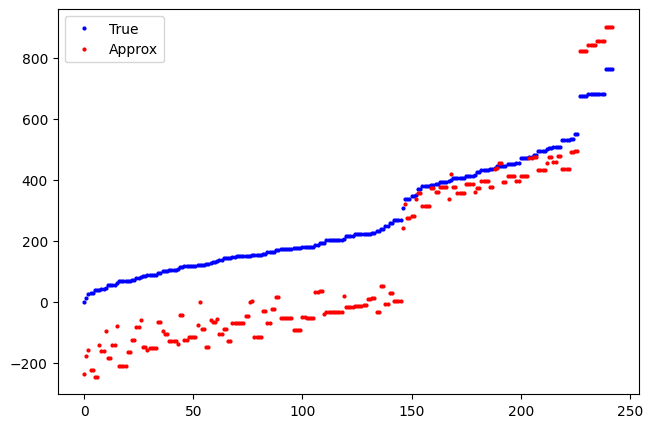

PyObject <matplotlib.legend.Legend object at 0x7fdcc41a0af0>

In [309]:
figure(figsize=((3/2)*5, 5))

ptSize = 2
PyPlot.plot(trueValues , "bo", label = "True", ms = ptSize)
PyPlot.plot(approxValues, "ro", label = "Approx", ms = ptSize)
legend()
#PyPlot.savefig("vfaVsTrue.pdf", bbox_inches="tight")

In [791]:
optDsps[run]

5-element Vector{Int64}:
 1
 0
 0
 0
 0

In [223]:
stateSpace[200:242]

43-element Vector{Any}:
 [1, 3, 2, 2, 1]
 [2, 2, 1, 2, 2]
 [3, 2, 1, 2, 2]
 [2, 3, 1, 2, 2]
 [3, 3, 1, 2, 2]
 [1, 2, 2, 2, 3]
 [1, 3, 2, 2, 3]
 [1, 1, 2, 2, 2]
 [2, 1, 2, 2, 1]
 [3, 1, 2, 2, 1]
 [2, 1, 2, 2, 3]
 [3, 1, 2, 2, 3]
 [2, 2, 2, 3, 3]
 ⋮
 [3, 3, 3, 2, 3]
 [2, 2, 3, 2, 2]
 [3, 2, 3, 2, 2]
 [2, 3, 3, 2, 2]
 [3, 3, 3, 2, 2]
 [2, 2, 2, 2, 3]
 [3, 2, 2, 2, 3]
 [2, 3, 2, 2, 3]
 [3, 3, 2, 2, 3]
 [2, 2, 2, 2, 2]
 [3, 2, 2, 2, 2]
 [2, 3, 2, 2, 2]

## Experiment 1

Replicate Experiment 11 using PD-VFA instead of SMARPE-based VFA
Exact PI on small problems, with small action space

In [282]:
taus_FAS = resultExp10["taus_FAS"]
c0s_FAS = resultExp10["c0s_FAS"]
optDspGs_FAS  = resultExp10["optDspGs_FAS"]
optDsps_FAS = resultExp10["optDsps_FAS"]
rs_FAS = resultExp10["rs_FAS"]
optGaps_FAS = resultExp10["optGaps_FAS"]
alphas_FAS = resultExp10["alphas_FAS"]
rviGs_FAS = resultExp10["rviGs_FAS"]
c1s_FAS = resultExp10["c1s_FAS"]
optPiGs_FAS = resultExp10["optPiGs_FAS"]

exactPIGFromPartDetVFA = []
exactPIFromPartDetVFA_gap = []
resRpisPartDet = []

epsilon = 1e-10
delScale = 1
nMax = 50000
numRuns = 1000
LEN_FRAME = 100
N = 5
alpha_d = fill(0.0, N)
beta = 1.0

for run in 1:numRuns
    #Start frame
    println(join(fill("-",LEN_FRAME)))
    print("Run: ")
    println(run)

    #get parameters
    tau = taus_FAS[run]
    print("tau: ")
    println(tau)

    alpha_r = alphas_FAS[run]
    print("alpha: ")
    println(alpha_r)

    c0 = c0s_FAS[run]
    print("c0: ")
    println(c0)

    c1 = c1s_FAS[run]
    print("c1: ")
    println(c1)

    r = rs_FAS[run]
    print("r: ")
    println(r)

    print("RVI: ")
    print(round(rviGs_FAS[run], digits = 5))

    #print exact heuristic result
    print(", Exact PI Heuristic: ")
    print(round(optPiGs_FAS[run], digits = 5))

    print(", Gap: ")
    println(round(optGaps_FAS[run], digits = 2))

    dcp = optDsps_FAS[run]
    g = optDspGs_FAS[run]
    h = hFromPartDetVFA(N, alpha_d, alpha_r, beta, tau, c0, c1, r, g, dcp; wR = 1.0, wE = 1.0)
    resRpi = rpiExact(N, h, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = nMax, delScale = delScale, printProgress = false, modCounter = 100, actionType = "full")
    g = resRpi[1]
    print("Approx PI Heuristic: ")
    print(round(g, digits = 5))

    gap = (g/rviGs_FAS[run] - 1.0)*100.0
    push!(exactPIFromPartDetVFA_gap, gap)
    print(", Optimality Gap: ")
    println(round(gap, digits = 2))
    push!(exactPIGFromPartDetVFA, resRpi[1])
    push!(resRpisPartDet, resRpi)
    #end frame
    println(join(fill("-",LEN_FRAME)))
end

----------------------------------------------------------------------------------------------------
Run: 1
tau: [0.9447905649425166, 0.866894886438913, 0.3396115028483221, 0.13611651795784874, 0.3225010866963668]
alpha: [0.008970179158651559, 0.036935810010869013, 0.059888020871150055, 0.03663215704203369, 0.0737056992956364]
c0: [0.09261145157968753, 0.11848853125656122, 0.26755021483368013, 0.8104947638539546, 0.8681535487443706]
c1: 853.4190042384113
r: [99.56147215735662, 82.000516419209, 83.4463081073842, 73.46937216084547, 38.36128790136257]
RVI: 4.70822, Exact PI Heuristic: 4.70822, Gap: 0.0
Approx PI Heuristic: 5.8768, Optimality Gap: 24.82
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Run: 2
tau: [0.9026092458595942, 0.33079891601205613, 0.13162494417125792, 0.1735229272258466, 0.13882745373884087]
alpha: [0.03063031765318

Excessive output truncated after 524296 bytes.

0.40256, Optimality Gap: 0.06
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Run: 684
tau: [0.4705646115246297, 0.4942340617266082, 0.37129097994778204, 0.3494695947274774, 0.8860096492394133]
alpha: [0.28255839946058303, 0.11439071066892766, 0.32406166679660897, 0.23177727450504854, 0.07941849849436665]
c0: [0.12801314762965654, 0.33385604465739793, 0.4115790580645141, 0.5730024410687521, 0.9987540698296962]
c1: 515.5946644567124
r: [78.67151306420371, 5.0021715597663, 83.40435577830853, 14.182307927609338,

In [599]:
for run in 1:numRuns
    exactPIFromVFA_gap_FAS[run] = (exactPIGFromVFA_FAS[run]/rviGs_FAS[run] - 1)*100
end

In [297]:
resultPDExp1 = Dict()
resultPDExp1["exactPIGFromPartDetVFA"] = exactPIGFromPartDetVFA
resultPDExp1["exactPIFromPartDetVFA_gap"] = exactPIFromPartDetVFA_gap

f = serialize("resultPDExp1.dat", resultPDExp1)


In [288]:
resultExp11 = deserialize("resultExp11.big")

Dict{Any, Any} with 3 entries:
  "exactPIGFromVFA_FAS"    => Any[4.70822, 0.97105, 0.589835, 8.82121, 0.551766…
  "exactPIFromVFA_gap_FAS" => Any[3.58824e-11, 2.90688, 0.0333175, 1.33058, -1.…
  "resRpis_FAS"            => Any[(4.70822, Dict{Any, Any}([3, 3, 1, 3, 3]=>218…

In [289]:
exactPIGFromVFA_FAS = resultExp11["exactPIGFromVFA_FAS"]
exactPIFromVFA_gap_FAS = resultExp11["exactPIFromVFA_gap_FAS"]

1000-element Vector{Any}:
  3.588240815588506e-11
  2.9068848934637126
  0.0333175089707094
  1.3305808386019802
 -1.8284889935493709e-6
  0.00043608902702274577
  2.220446049250313e-13
 -2.8976820942716586e-12
  0.03405068683599577
  0.8245309096063691
  0.037170704604894134
 28.636322845056327
  5.744917921379766e-5
  ⋮
  0.0
  2.4424906541753444e-13
  8.762187419295287
  0.00023464836138575862
 -6.06914783984891e-6
 12.304190604086829
  0.1470215908315975
  0.6479697403590778
  4.243272400117348e-11
 -3.9968028886505635e-13
  0.005307793772679759
  1.4654943925052066e-12

In [284]:
mean(exactPIFromPartDetVFA_gap)

54.2813843684904

In [287]:
median(exactPIFromPartDetVFA_gap)

35.44621179360982

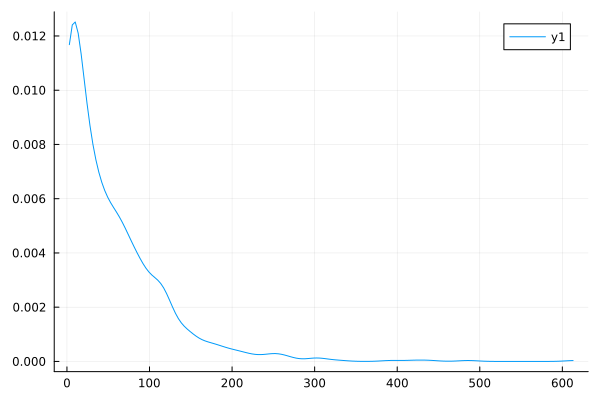

In [286]:
density(exactPIFromPartDetVFA_gap, trim = true)

In [189]:
optDspGs = resultExp10["optDspGs_FAS"]
vfaImp = 100*( (optDspGs - exactPIGFromVFA_FAS)./optDspGs )

1000-element Vector{Float64}:
  5.846291389412493e-9
  1.8129069025087056e-8
  4.2438334407419775
 19.67555338955179
  6.449287432741529e-8
 -9.894447692788105e-7
  1.9496960792272373
 13.423295588623704
  1.1907671195769682
 19.78187317108603
  0.550102951671923
 -8.428957249359488
  0.17203075309207302
  ⋮
  0.9508656434499505
 24.60596362702349
 23.21532084604453
  0.701562831284114
  2.325852934961634e-8
  3.6835896760543894
  1.6878347181453721
  3.5508827873502976e-9
 29.825969994082378
  1.9580268829201597
  3.7986766881846e-8
  8.59033830593189

In [190]:
mean(vfaImp)

5.545291402128639

In [292]:
dspGaps = [(optDspGs_FAS[i]/rviGs_FAS[i] - 1)*100 for i in 1:1000]

1000-element Vector{Float64}:
  5.882161424608512e-9
  2.906884912119767
  4.466710712636779
 26.151607778921694
 -1.7639961269466653e-6
  0.0004350995779445199
  1.9884651054247193
 15.50451207387027
  1.2395782971973857
 25.68796467242487
  0.5905221359771007
 18.636502746424966
  0.1723847570670678
  ⋮
  0.9599938955822562
 32.63648533857149
 41.64568845983456
  0.7067558157567877
 -6.045889311412367e-6
 16.59922771869171
  1.866357336059643
  0.6479697439329746
 42.502860376708675
  1.9971312496755989
  0.00530783176146965
  9.39762618822908

In [744]:
mean(optGaps_FAS[i] < 1e-2 for i in 1:1000)

0.524

In [764]:
mean(dspGaps[i] < 1e-2 for i in 1:1000)

0.173

In [592]:
mean(optGaps_FAS)

1.3785583639770735

In [765]:
mean(dspGaps)

12.490127169785017

In [593]:
median(optGaps_FAS)

0.005911872321273659

In [766]:
median(dspGaps)

4.627495156466299

In [768]:
quantile(optGaps_FAS, 0.9)

4.498998444625582

In [767]:
quantile(dspGaps, 0.9)

31.949286822138617

In [606]:
quantile(optGaps_FAS, 0.99)

21.73081866793912

In [769]:
quantile(dspGaps, 0.99)

95.72587814407996

In [770]:
maximum(optGaps_FAS)

42.83074769222086

In [771]:
maximum(dspGaps)

333.4094211222235

In [781]:
sum(gap > 42.83 for gap in exactPIFromVFA_gap_FAS)

10

In [782]:
[i for i in 1:1000 if dspGaps[i] > 300]

1-element Vector{Int64}:
 984

In [783]:
exactPIFromVFA_gap_FAS[984]

344.17773434186074

In [747]:
mean(gap < 0.01 for gap in exactPIFromVFA_gap_FAS)

0.358

In [603]:
mean(exactPIFromVFA_gap_FAS)

4.1861161902709085

In [604]:
median(exactPIFromVFA_gap_FAS)

0.12971059818376318

In [608]:
quantile(exactPIFromVFA_gap_FAS, 0.9)

8.292287859893522

In [609]:
quantile(exactPIFromVFA_gap_FAS, 0.99)

42.13691088542402

In [780]:
maximum(exactPIFromVFA_gap_FAS)

699.8178538990456

In [641]:
sum(optPiGs_FAS[i] - optDspGs[i] > 1e-10 for i in 1:numRuns)

63

In [640]:
sum(exactPIGFromVFA_FAS[i] - optDspGs[i] > 1e-10 for i in 1:numRuns)

80

In [639]:
[exactPIGFromVFA_FAS[i] - optDspGs[i] for i in 1:numRuns if exactPIGFromVFA_FAS[i] - optDspGs[i] > 1e-5 ]

49-element Vector{Float64}:
 0.08252663442420849
 1.1448216125450916
 3.258650075055325e-5
 2.0983678497545633
 1.8289222474962266
 0.0032832412172382197
 0.1978669823109621
 0.00108499081141894
 0.10383908339682135
 2.326066561796946
 0.03304250576636508
 0.40336073986490506
 0.007432279918634155
 ⋮
 1.5212769983666785
 0.20936978764510616
 0.1427008417793756
 0.12732507825655237
 0.8088630155683307
 0.11525843663075208
 0.17637718463934116
 0.017894177997775984
 0.26638290944635745
 0.02095957435279594
 2.6365049094360025
 0.01590229774145957

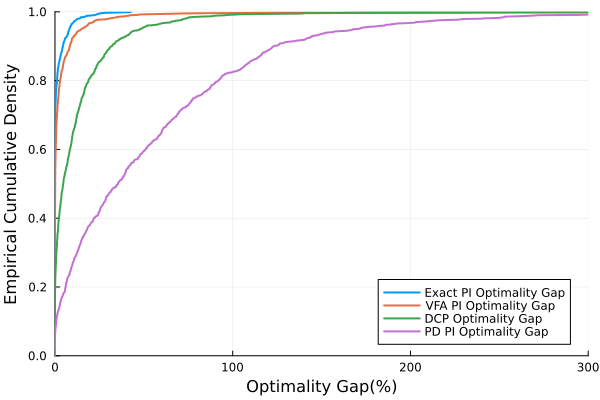

In [299]:
StatsPlots.plot(sort(optGaps_FAS), (1:1000)./1000, label = "Exact PI Optimality Gap", ylim = (0,1), xlabel = "Optimality Gap(%)", ylabel = "Empirical Cumulative Density", linewidth = 2, size = (600,400))
StatsPlots.plot!(sort(exactPIFromVFA_gap_FAS),(1:1000)./1000, label = "VFA PI Optimality Gap", xlim = (0,300), linewidth = 2)
StatsPlots.plot!(sort(dspGaps), (1:1000)./1000, label = "DCP Optimality Gap", linewidth = 2)
StatsPlots.plot!(sort(exactPIFromPartDetVFA_gap), (1:1000)./1000, label = "PD PI Optimality Gap", linewidth = 2)
#StatsPlots.savefig("threeDensities.pdf")

# Experiments on Large Problems

## Experiment 1

In [101]:
nMaxSmarpe = 1000000
nMaxgEval = 1000000

N = 10
tau = fill(1.0, N)
alpha_d = fill(0.0, N)
alpha_r = [1.0*i for i in 1:N]
beta = 10.0
c0 = [1.0*i for i in 1:N]
c1 = 100.0
r = [100.0*i for i in 1:N]

dsp, g, counter = jointHeuristic(N, alpha_d, alpha_r, beta, tau, c0, c1, r)

println("DCP Found")

mcp = Array{Any}(nothing, N)
for i in 1:N
    if dsp[i] == 1
        mcp[i] = -1
    else
        mcp[i] = alpha_r[i]*(1000/999 - 1.0)
    end
end

#Calculate g of mu-soft dsp
mu = copy(mcp)
for i in 1:N
    if mu[i] == -1
        mu[i] = 1e10
    end
end

gSoft = calculateG_SSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, mu)[1]

print("DCP g: ")
print(round(g, digits = 2))
print(", Soft DCP g: ")
println(round(gSoft, digits = 2))

#find smarpe vfa of mcp
Random.seed!(12345)
resSMARPE = smarpeNewVFA_ST_MCP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMaxSmarpe, 0.0, mcp;  ve = Dict(), vn = Dict(), vfaProvided = false, g = gSoft, gFixed = true, s = fill(1,N), stateTrace = [], timePassed = 0.0, printProgress = true, modCounter = 100000)
ve = resSMARPE[1]["ve"]
vn = resSMARPE[1]["vn"]

#evaluate PI policy from smarpe vfa
Random.seed!(12345)
gsPI = gEvaluationNewVFA(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMaxgEval, ve, vn, gSoft, printProgress = true, modCounter = 100000)


DCP Found
DCP g: 525.0, Soft DCP g: 529.15
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000


(501.6182004724122, [0.0, 10.0, 10.000000000000002, 10.000000000000002, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0  …  501.6151527795583, 501.6151527795583, 501.61604850018404, 501.61551332456105, 501.61551332456105, 501.61640904252124, 501.61640904252124, 501.6173047584716, 501.6173047584716, 501.6182004724122])

Good start!

## Experiment 2

In [124]:
Random.seed!(12345)
N = 10
beta = 1.0
alpha_d = fill(0.0, N)
taus = []
alphas = []
c0s = []
c1s = []
rs = []
TAU_MAX = 1.0
C0_MAX = 1.0
C1_MAX = 1000.0
R_MAX = 100.0

for i in 1:1000
    tau = rand(N).*TAU_MAX 
    push!(taus, tau)
    alpha = [sampleTruncExp(minimum(tau)/2, minimum(tau)) for i in 1:N]
    push!(alphas, alpha)
    c0 = rand(N).*C0_MAX
    c0 = sort(c0)
    push!(c0s, c0)
    c1 = C0_MAX + rand()*(C1_MAX - C0_MAX)
    push!(c1s, c1)
    r = rand(N).*R_MAX
    push!(rs, r)
end

In [316]:
nMaxSmarpe = 1000000
nMaxgEval = 1000000
dcps = []
dcpGs = []
dcpSoftGs = []
piGs = []
for i in 1:1000
    println("-----------------------------------------------------------------")
    #get parameters
    tau = taus[i]
    print("tau: ")
    println([round(tau[i], digits = 5) for i in 1:N])

    alpha_r = alphas[i]
    print("alpha_r: ")
    println([round(alpha_r[i], digits = 5) for i in 1:N])

    c0 = c0s[i]
    print("c0: ")
    println([round(c0[i], digits = 5) for i in 1:N])

    c1 = c1s[i]
    print("c1: ")
    println(round(c1, digits = 5))

    r = rs[i]
    print("r: ")
    println([round(r[i], digits = 5) for i in 1:N])

    dcp, g, counter = jointHeuristic(N, alpha_d, alpha_r, beta, tau, c0, c1, r)
    push!(dcps, dcp)
    push!(dcpGs, g)

    print("DCP: ")
    println(dcp)

    mcp = Array{Any}(nothing, N)
    for i in 1:N
        if dcp[i] == 1
            mcp[i] = -1
        else
            mcp[i] = alpha_r[i]*(1/999)
        end
    end

    #Calculate g of mu-soft dsp
    mu = copy(mcp)
    for i in 1:N
        if mu[i] == -1
            mu[i] = 1e10
        end
    end

    gSoft = calculateG_SSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, mu)[1]
    push!(dcpSoftGs, gSoft)

    print("DCP g: ")
    print(round(g, digits = 5))
    print(", Soft DCP g: ")
    println(round(gSoft, digits = 5))

    #find smarpe vfa of mcp
    Random.seed!(12345)
    resSMARPE = smarpeNewVFA_ST_DCP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMaxSmarpe, 0.0, mcp;  ve = Dict(), vn = Dict(), vfaProvided = false, g = g, gFixed = true, s = fill(1,N), stateTrace = [], timePassed = 0.0, printProgress = false, modCounter = 100000)
    println("SMARPE Complete")
    ve = resSMARPE["ve"]
    vn = resSMARPE["vn"]

    #evaluate PI policy from smarpe vfa
    Random.seed!(12345)
    gsPI = gEvaluationNewVFA_DCP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMaxgEval, ve, vn, g, dcp, printProgress = false, modCounter = 100000)
    push!(piGs, gsPI[1])
    print("PI g:")
    println(round(gsPI[1], digits = 5))
    println("-----------------------------------------------------------------")
end


-----------------------------------------------------------------
tau: [0.79181, 0.15958, 0.33419, 0.81139, 0.79663, 0.91781, 0.31133, 0.75291, 0.63385, 0.89995]
alpha_r: [0.04209, 0.00092, 0.08004, 0.00174, 0.0383, 0.05824, 0.03548, 0.02483, 0.00868, 0.07356]
c0: [0.05805, 0.08217, 0.16504, 0.20717, 0.27659, 0.36701, 0.39868, 0.81137, 0.92479, 0.97376]
c1: 835.69729
r: [58.08576, 41.21976, 55.95246, 59.85141, 26.05061, 29.5834, 26.19536, 74.49579, 7.75329, 86.68002]
DCP: [0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
DCP g: 0.45756, Soft DCP g: 0.48588
SMARPE Complete
PI g:1.57169
-----------------------------------------------------------------
-----------------------------------------------------------------
tau: [0.85452, 0.78337, 0.86949, 0.23438, 0.34336, 0.83449, 0.07255, 0.98995, 0.53934, 0.65504]
alpha_r: [0.01122, 0.04989, 0.05157, 0.00445, 0.0531, 0.05171, 0.0495, 0.04895, 0.02736, 0.01805]
c0: [0.2568, 0.37444, 0.44573, 0.59938, 0.61427, 0.68416, 0.72628, 0.8066, 0.80894, 0.83744]
c1: 302.

Excessive output truncated after 524295 bytes.

PI g:1.21236
-----------------------------------------------------------------
-----------------------------------------------------------------
tau: [0.85915, 0.51095, 0.37699, 0.65289, 0.14348, 0.0074, 0.81943, 0.79526, 0.64208, 0.16373]
alpha_r: [0.00177, 0.00022, 0.00331, 0.00036, 0.00233, 0.00414, 0.00294, 4.0e-5, 0.0068, 

In [317]:
largeResultExp2 = Dict()
largeResultExp2["dcps"] = dcps
largeResultExp2["dcpGs"] = dcpGs
largeResultExp2["dcpSoftGs"] = dcpSoftGs
largeResultExp2["piGs"] = piGs

f = serialize("largeResultExp2.dat", largeResultExp2)

In [318]:
improvement = ((dcpGs - piGs)./dcpGs).*100

1000-element Vector{Float64}:
 -243.49394815579265
    7.380845586209695
    1.0809778855065164
    0.05398809280964032
    0.14198900424294728
    0.2498113829775964
    0.717884245450662
    0.3716782801880727
   37.77136133183146
 -149.8532923336544
   -0.02191476041034175
 -134.04464431983527
   -0.09289071541379618
    ⋮
    1.7896841054961588
   13.841968624624382
 -183.03742238732482
    0.9714367362683312
   15.490654763765551
    0.049157650480199024
    8.166115617664945
    4.269377588556234
    5.220033681498876
    4.2406720709569035
    0.23297979146688375
   30.840329344266483

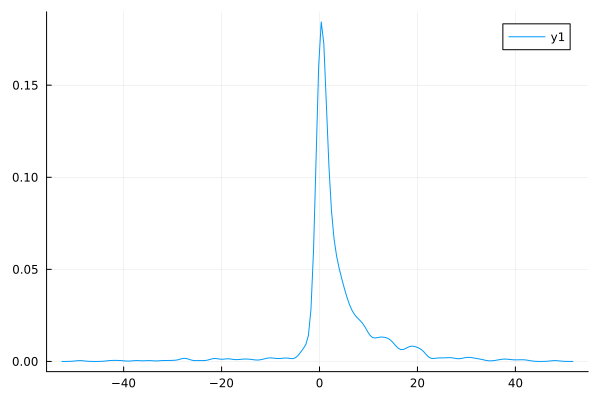

In [327]:
lim = 50
density([i for i in improvement if abs(i) < lim])

In [320]:
positiveImprovement = [i for i in improvement if i >= 0]

828-element Vector{Float64}:
  7.380845586209695
  1.0809778855065164
  0.05398809280964032
  0.14198900424294728
  0.2498113829775964
  0.717884245450662
  0.3716782801880727
 37.77136133183146
  1.1566299659113868
 14.2577334969162
 12.120137709545054
  0.30157655409915385
  9.868751891687586
  ⋮
  1.8355070175478747
  1.7896841054961588
 13.841968624624382
  0.9714367362683312
 15.490654763765551
  0.049157650480199024
  8.166115617664945
  4.269377588556234
  5.220033681498876
  4.2406720709569035
  0.23297979146688375
 30.840329344266483

In [321]:
mean(positiveImprovement)

5.008631150090688

In [328]:
median(positiveImprovement)

2.055563702255622

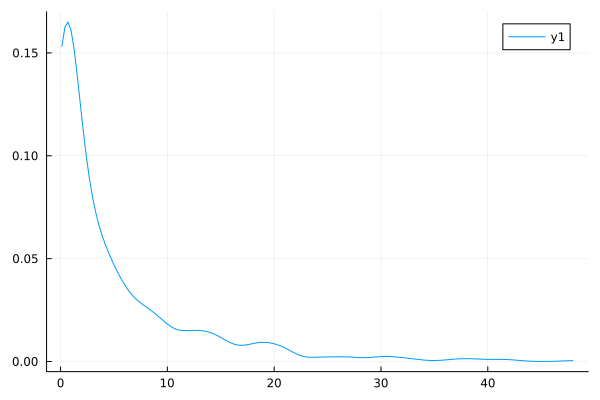

In [323]:
density(positiveImprovement, trim = true)

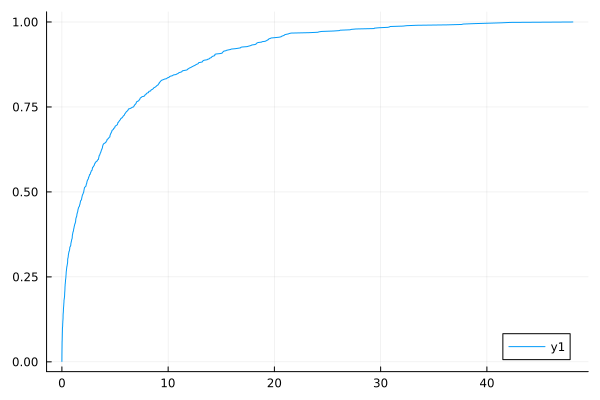

In [329]:
StatsPlots.plot(sort(positiveImprovement), (1:828)./828)

In [324]:
minimum(improvement)

-892.3358807390647

In [325]:
maximum(positiveImprovement)

48.09135806874787

## Experiment 3

Investigation into simulation error

In [245]:
nMaxSmarpe = 1000000
nMaxgEval = 1000000
dcps = []
exactGs = []
simGs = []
relErrors = []
for i in 1:1000
    println("-----------------------------------------------------------------")
    #get parameters
    tau = taus[i]
    print("tau: ")
    println([round(tau[i], digits = 5) for i in 1:N])

    alpha_r = alphas[i]
    print("alpha_r: ")
    println([round(alpha_r[i], digits = 5) for i in 1:N])

    c0 = c0s[i]
    print("c0: ")
    println([round(c0[i], digits = 5) for i in 1:N])

    c1 = c1s[i]
    print("c1: ")
    println(round(c1, digits = 5))

    r = rs[i]
    print("r: ")
    println([round(r[i], digits = 5) for i in 1:N])

    dcp, g, counter = jointHeuristic(N, alpha_d, alpha_r, beta, tau, c0, c1, r)
    push!(dcps, dcp)
    push!(exactGs, g)

    print("DCP: ")
    println(dcp)

    print("Exact DCP g: ")
    println(round(g, digits = 5))

    #Simulated g value
    Random.seed!(12345)
    gs = gEvaluationDSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMaxgEval, dcp; s = fill(1, N),  epsilon = -1.0, printProgress = false, modCounter = 100000, forceActive = false, stateTrace = false)
    push!(simGs, gs[1])
    print("Sim DCP g:")
    println(round(gs[1], digits = 5))

    #Find error 
    error = 100*( (g - gs[1])/g )
    push!(relErrors, error)
    print("Error: ")
    print(round(error, digits = 5))
    println("%")
    println("-----------------------------------------------------------------")
end


-----------------------------------------------------------------
tau: [0.79181, 0.15958, 0.33419, 0.81139, 0.79663, 0.91781, 0.31133, 0.75291, 0.63385, 0.89995]
alpha_r: [0.04209, 0.00092, 0.08004, 0.00174, 0.0383, 0.05824, 0.03548, 0.02483, 0.00868, 0.07356]
c0: [0.05805, 0.08217, 0.16504, 0.20717, 0.27659, 0.36701, 0.39868, 0.81137, 0.92479, 0.97376]
c1: 835.69729
r: [58.08576, 41.21976, 55.95246, 59.85141, 26.05061, 29.5834, 26.19536, 74.49579, 7.75329, 86.68002]
DCP: [0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
Exact DCP g: 0.45756
Sim DCP g:0.45686
Error: 0.15356%
-----------------------------------------------------------------
-----------------------------------------------------------------
tau: [0.85452, 0.78337, 0.86949, 0.23438, 0.34336, 0.83449, 0.07255, 0.98995, 0.53934, 0.65504]
alpha_r: [0.01122, 0.04989, 0.05157, 0.00445, 0.0531, 0.05171, 0.0495, 0.04895, 0.02736, 0.01805]
c0: [0.2568, 0.37444, 0.44573, 0.59938, 0.61427, 0.68416, 0.72628, 0.8066, 0.80894, 0.83744]
c1: 302.50394
r: [

Excessive output truncated after 524302 bytes.

Sim DCP g:1.46877
Error: -0.15134%

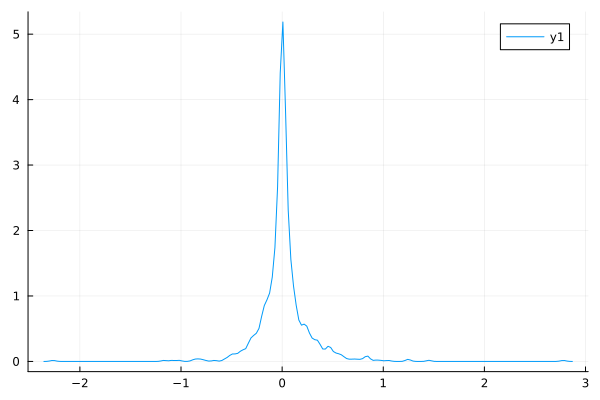

In [255]:
density(relErrors)

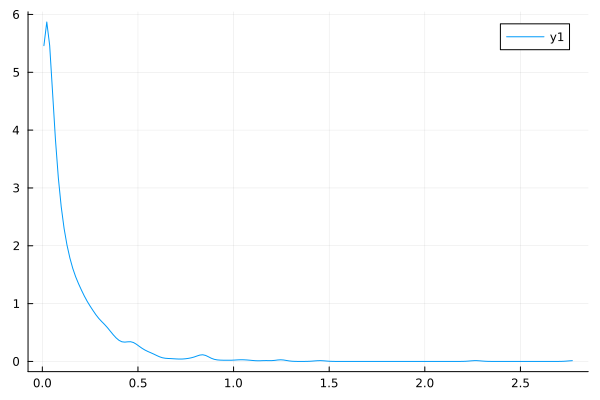

In [250]:
density(abs.(relErrors), trim = true)

In [248]:
mean(abs.(relErrors))

0.14063188724828243

In [256]:
sum(abs(r) <= 1 for r in relErrors)

991